Ingénierie des caractéristiques et sélection des caractéristiques 

Dans cette section, nous commencerons par les connaissances et les idées acquises grâce à l’analyse exploratoire des données pour créer de bons ensembles de caractéristiques à l’aide de l’ingénierie des caractéristiques. 

Une chose à noter ici est que la plupart des fonctionnalités générées sont basées sur la connaissance du domaine et des expérimentations. Sans de bons ensembles de fonctionnalités, les algorithmes d’apprentissage automatique ne peuvent pas produire de résultats efficaces. Par conséquent, nous devrons trouver des moyens ingénieux de faire de l’ingénierie des caractéristiques pour que le modèle prenne de meilleures décisions. 

Outre la génération de fonctionnalités importantes/utiles, il est également essentiel de supprimer les fonctionnalités redondantes et bruyantes. Si nous introduisons des déchets/du bruit dans notre modèle d’apprentissage automatique, il renverra par conséquent des déchets/du bruit. Nous devons donc trouver de bonnes techniques de sélection de caractéristiques.

Modelisation

Une fois que nous en aurons terminé avec l’ingénierie des fonctionnalités, nous passerons à la modélisation de l’apprentissage automatique. Nous commencerons par des algorithmes simples mais puissants comme la régression logistique, la SVM linéaire, etc., puis nous passerons à des ensembles tels que les forêts aléatoires, les techniques de boosting, et enfin les techniques d’empilement. Nous choisirons les modèles qui donnent le meilleur résultat.

In [58]:
#importing Useful applicatication_trainStructures
import pandas as pd
import numpy as np
from scipy.stats import uniform

#importing plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

#importing Misc Libraries
import os
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#sklearn
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import roc_auc_score,precision_score,recall_score,roc_curve,confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV

#other modelling libraries
from bayes_opt import BayesianOptimization
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
import missingno as msno

from functions import *

### process bureau et bureau_balance

bureau_balance.csv et bureau.csv
Ces tableaux contiennent les informations relatives aux crédits antérieurs du client qui n’étaient pas avec Home Credit Group, et ont été déclarés par le service de l’agence d’évaluation du crédit.


bureau_balance
Tout d’abord, la table bureau_balance contient trois champs, c’est-à-dire SK_ID_BUREAU, MONTHS_BALANCE et STATUS.
Comme le Status suit un comportement quelque peu ordinal, nous commençons par l’étiqueter en l’encodant.

Ensuite, certaines entités sont créées, telles que l’état pondéré, qui est obtenu en divisant l’état par le MONTHS_BALANCE.

Étant donné que les données contiennent la série chronologique, nous calculons également la moyenne mobile pondérée exponentielle des champs Statut et Statut pondéré.

Enfin, nous agrégeons les données sur SK_ID_BUREAU, de telle sorte que nous les agrégeons d’abord sur toutes les données, puis nous les agrégeons également sur les 2 dernières années. Ces 2 années dépeindraient le comportement plus récent des clients.

Les agrégations effectuées sont basées sur la connaissance du domaine, telles que la moyenne, le minimum, le maximum, la somme, le nombre, etc. Pour les fonctionnalités EDA, nous ne prenons que les dernières valeurs/les plus récentes, car elles contiennent en quelque sorte la tendance de toutes les valeurs précédentes.



bureau
Tout d’abord, nous fusionnons la table bureau avec la table agrégée bureau_balance de l’étape précédente, sur SK_ID_BUREAU.

Nous remplaçons certaines valeurs erronées par des valeurs NaN. Nous avons vu des prêts qui remontent à il y a 100 ans. Nous pensons qu’ils n’en diront pas grand-chose sur le comportement récent du client, alors nous les supprimons et ne conservons les prêts que sur une période de 50 ans.

Nous créons certaines caractéristiques par multiplications, divisions, soustractions de caractéristiques brutes, en fonction de la connaissance du domaine, telles que la durée du crédit, le ratio annuité/crédit, etc.

Les données catégorielles sont one hot encodées.

Pour les fusionner dans la table principale, c’est-à-dire application_train, nous agrégeons cette table sur SK_ID_CURR. Nous effectuons à nouveau les agrégations de deux manières. Nous agrégeons les crédits en fonction de la catégorie CREDIT_ACTIVE, où nous agrégeons séparément les deux catégories les plus populaires, c’est-à-dire Actif et Fermé. Plus tard, nous agrégeons également les catégories restantes et les fusionnons. Nous avons également agrégé l’ensemble des données. Les agrégations effectuées sont la somme, la moyenne, le min, le max, le dernier, etc.


##### BUREAU_BALANCE

In [2]:
bureau_balance = pd.read_csv('data/bureau_balance.csv')

In [3]:
dict_for_status = { 'C': 0, '0': 1, '1': 2, '2': 3, 'X': 4, '3': 5, '4': 6, '5': 7}
bureau_balance['STATUS'] = bureau_balance['STATUS'].map(dict_for_status)


In [4]:
#weighing the status with the months_balance
#converting months to positive
bureau_balance['MONTHS_BALANCE'] = np.abs(bureau_balance['MONTHS_BALANCE'])
bureau_balance['WEIGHTED_STATUS'] = bureau_balance.STATUS / (bureau_balance.MONTHS_BALANCE + 1)

# pas compris


In [5]:

#sorting the bureau_balance in ascending order of month and by the bureau SK_ID
#this is done so as to make the rolling exponential average easily for previous months till current month
bureau_balance = bureau_balance.sort_values(by=['SK_ID_BUREAU', 'MONTHS_BALANCE'], ascending=[0, 0])
        

In [6]:
#we will do exponential weighted average on the encoded status
#this is because if a person had a bad status 2 years ago, it should be given less weightage today
# we keep the latent variable alpha = 0.8 
#doing this for both weighted status and the status itself
bureau_balance['EXP_WEIGHTED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['WEIGHTED_STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())
bureau_balance['EXP_ENCODED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())    


In [7]:
#we can see that these application_trainpoints are for 96 months i.e. 8 years.
#so we will extract the means, and exponential averages for each year separately
#first we convert month to year
bureau_balance['MONTHS_BALANCE'] = bureau_balance['MONTHS_BALANCE'] // 12

#On peut voir que ces application_trainpoints sont pour 96 mois, c’est-à-dire 8 ans.
#Nous allons donc extraire les moyennes et les moyennes exponentielles pour chaque année séparément
#Tout d’abord, nous convertissons le mois en année


In [8]:
#defining our aggregations
aggregations_basic = {
    'MONTHS_BALANCE' : ['mean','max'],
    'STATUS' : ['mean','max','first'],
    'WEIGHTED_STATUS' : ['mean','sum','first'],
    'EXP_ENCODED_STATUS' : ['last'],
    'EXP_WEIGHTED_STATUS' : ['last']}

In [9]:
#we will be finding aggregates for each year too
aggregations_for_year = {
    'STATUS' : ['mean','max','last','first'],
    'WEIGHTED_STATUS' : ['mean','max', 'first','last'],
    'EXP_WEIGHTED_STATUS' : ['last'],
    'EXP_ENCODED_STATUS' : ['last'] }

In [10]:
#aggregating over whole set first
aggregated_bureau_balance = bureau_balance.groupby(['SK_ID_BUREAU']).agg(aggregations_basic)
aggregated_bureau_balance.columns = ['_'.join(ele).upper() for ele in aggregated_bureau_balance.columns]


In [11]:
aggregated_bureau_balance

,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_MAX,STATUS_MEAN,STATUS_MAX,STATUS_FIRST,WEIGHTED_STATUS_MEAN,WEIGHTED_STATUS_SUM,WEIGHTED_STATUS_FIRST,EXP_ENCODED_STATUS_LAST,EXP_WEIGHTED_STATUS_LAST
SK_ID_BUREAU,,,,,,,,,,
5001709,3.546392,8,0.453608,4,4,0.004936,0.478827,0.041237,3.094850e-60,3.547249e-62
5001710,2.963855,6,1.506024,4,4,0.022689,1.883185,0.048193,4.166370e-34,8.419081e-36
5001711,0.000000,0,1.750000,4,1,1.270833,5.083333,0.250000,3.403846e+00,3.297543e+00
5001712,0.368421,1,0.526316,1,1,0.037830,0.718771,0.052632,5.119999e-07,5.008223e-08
5001713,0.454545,1,4.000000,4,4,0.671057,14.763253,0.181818,4.000000e+00,3.570297e+00
...,...,...,...,...,...,...,...,...,...,...
6842884,1.500000,3,1.770833,4,4,0.058626,2.814045,0.083333,4.194304e-14,1.975070e-15
6842885,0.500000,1,4.000000,7,1,0.933134,22.395222,0.041667,7.000000e+00,6.248019e+00
6842886,0.909091,2,0.242424,1,1,0.008268,0.272840,0.030303,3.355435e-18,1.278811e-19


In [12]:
#aggregating some of the features separately for latest 2 years
aggregated_bureau_years = pd.DataFrame()
for year in range(2):
    year_group = bureau_balance[bureau_balance['MONTHS_BALANCE'] == year].groupby('SK_ID_BUREAU').agg(aggregations_for_year)
    year_group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in year_group.columns]
    if year == 0:
        aggregated_bureau_years = year_group
    else:
        aggregated_bureau_years = aggregated_bureau_years.merge(year_group, on = 'SK_ID_BUREAU', how = 'outer')


In [13]:
#aggregating for rest of the years
aggregated_bureau_rest_years = bureau_balance[bureau_balance.MONTHS_BALANCE > year].groupby(['SK_ID_BUREAU']).agg(aggregations_for_year)
aggregated_bureau_rest_years.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in aggregated_bureau_rest_years.columns]


In [14]:
#merging with rest of the years
aggregated_bureau_years = aggregated_bureau_years.merge(aggregated_bureau_rest_years, on = 'SK_ID_BUREAU', how = 'outer')
aggregated_bureau_balance = aggregated_bureau_balance.merge(aggregated_bureau_years, on = 'SK_ID_BUREAU', how = 'inner')


In [15]:
#filling the missing values obtained after aggregations with 0
aggregated_bureau_balance.fillna(0, inplace = True)

In [16]:
aggregated_bureau_balance

,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_MAX,STATUS_MEAN,STATUS_MAX,STATUS_FIRST,WEIGHTED_STATUS_MEAN,WEIGHTED_STATUS_SUM,WEIGHTED_STATUS_FIRST,EXP_ENCODED_STATUS_LAST,EXP_WEIGHTED_STATUS_LAST,...,STATUS_MEAN_YEAR_REST,STATUS_MAX_YEAR_REST,STATUS_LAST_YEAR_REST,STATUS_FIRST_YEAR_REST,WEIGHTED_STATUS_MEAN_YEAR_REST,WEIGHTED_STATUS_MAX_YEAR_REST,WEIGHTED_STATUS_FIRST_YEAR_REST,WEIGHTED_STATUS_LAST_YEAR_REST,EXP_WEIGHTED_STATUS_LAST_YEAR_REST,EXP_ENCODED_STATUS_LAST_YEAR_REST
SK_ID_BUREAU,,,,,,,,,,,,,,,,,,,,,
5001709,3.546392,8,0.453608,4,4,0.004936,0.478827,0.041237,3.094850e-60,3.547249e-62,...,0.602740,4.0,0.0,4.0,0.006559,0.045977,0.041237,0.00,2.114325e-45,1.844674e-43
5001710,2.963855,6,1.506024,4,4,0.022689,1.883185,0.048193,4.166370e-34,8.419081e-36,...,2.118644,4.0,0.0,4.0,0.031918,0.080000,0.048193,0.00,5.018163e-19,2.483350e-17
5001711,0.000000,0,1.750000,4,1,1.270833,5.083333,0.250000,3.403846e+00,3.297543e+00,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000e+00,0.000000e+00
5001712,0.368421,1,0.526316,1,1,0.037830,0.718771,0.052632,5.119999e-07,5.008223e-08,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000e+00,0.000000e+00
5001713,0.454545,1,4.000000,4,4,0.671057,14.763253,0.181818,4.000000e+00,3.570297e+00,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6842884,1.500000,3,1.770833,4,4,0.058626,2.814045,0.083333,4.194304e-14,1.975070e-15,...,2.875000,4.0,4.0,4.0,0.087549,0.160000,0.083333,0.16,1.584893e-01,4.000000e+00
6842885,0.500000,1,4.000000,7,1,0.933134,22.395222,0.041667,7.000000e+00,6.248019e+00,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000e+00,0.000000e+00
6842886,0.909091,2,0.242424,1,1,0.008268,0.272840,0.030303,3.355435e-18,1.278811e-19,...,0.888889,1.0,0.0,1.0,0.030316,0.038462,0.030303,0.00,7.622312e-03,1.999996e-01


#### eda sur cete table enrichie avec la target

In [17]:
def plot_phik_matrix(data, categorical_columns, figsize = (20,20), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):
    
    '''
    Function to Phi_k matrix for categorical features
    
    Inputs:
        data: DataFrame
            The DataFrame from which to build correlation matrix
        categorical_columns: list
            List of categorical columns whose PhiK values are to be plotted
        figsize: tuple, default = (25,23)
            Size of the figure to be plotted
        mask_upper: bool, default = True
            Whether to plot only the lower triangle of heatmap or plot full.
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        linewidth: float/int, default = 0.1
            The linewidth to use for heatmap
        fontsize: int, default = 10
            The font size for the X and Y tick labels
        cmap: str, default = 'Blues'
            The colormap to be used for heatmap
        show_target_top_corr: bool, default = True
            Whether to show top/highly correlated features with Target.
        target_top_columns: int, default = 10
            The number of top correlated features with target to display
    '''
    
    #first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()
    
    print('-'*100)
    
    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)
        
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100) 

##### BUREAU

In [18]:
#### bureau
bureau = pd.read_csv('data/bureau.csv')

In [19]:
#merging it with aggregated bureau_balance on 'SK_ID_BUREAU'
bureau_merged = bureau.merge(aggregated_bureau_balance, on = 'SK_ID_BUREAU', how = 'left')


In [20]:
#from the EDA we saw some erroneous values in DAYS Fields, we will remove those
#there are some loans which ended about very long ago, around 100 years ago.
#Thus we will only keep those loans which have ended in past 50 years.
bureau_merged['DAYS_CREDIT_ENDDATE'][bureau_merged['DAYS_CREDIT_ENDDATE'] > -50*365] = np.nan
bureau_merged['DAYS_ENDDATE_FACT'][bureau_merged['DAYS_ENDDATE_FACT'] > -50*365] = np.nan
#there is also a feature which tells about the number of days ago the Credit Report Came
bureau_merged['DAYS_CREDIT_UPDATE'][bureau_merged['DAYS_CREDIT_UPDATE'] > -50*365] = np.nan

#engineering some features based on domain knowledge
bureau_merged['CREDIT_DURATION'] = np.abs(bureau_merged['DAYS_CREDIT'] - bureau_merged['DAYS_CREDIT_ENDDATE'])
bureau_merged['FLAG_OVERDUE_RECENT'] = [0 if ele == 0 else 1 for ele in bureau_merged['CREDIT_DAY_OVERDUE']]
bureau_merged['MAX_AMT_OVERDUE_DURATION_RATIO'] = bureau_merged['AMT_CREDIT_MAX_OVERDUE'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
bureau_merged['CURRENT_AMT_OVERDUE_DURATION_RATIO'] = bureau_merged['AMT_CREDIT_SUM_OVERDUE'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
bureau_merged['AMT_OVERDUE_DURATION_LEFT_RATIO'] = bureau_merged['AMT_CREDIT_SUM_OVERDUE'] / (bureau_merged['DAYS_CREDIT_ENDDATE'] + 0.00001)
bureau_merged['CNT_PROLONGED_MAX_OVERDUE_MUL'] = bureau_merged['CNT_CREDIT_PROLONG'] * bureau_merged['AMT_CREDIT_MAX_OVERDUE']
bureau_merged['CNT_PROLONGED_DURATION_RATIO'] = bureau_merged['CNT_CREDIT_PROLONG'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
bureau_merged['CURRENT_DEBT_TO_CREDIT_RATIO'] = bureau_merged['AMT_CREDIT_SUM_DEBT'] / (bureau_merged['AMT_CREDIT_SUM'] + 0.00001)
bureau_merged['CURRENT_CREDIT_DEBT_DIFF'] = bureau_merged['AMT_CREDIT_SUM'] - bureau_merged['AMT_CREDIT_SUM_DEBT']
bureau_merged['AMT_ANNUITY_CREDIT_RATIO'] = bureau_merged['AMT_ANNUITY'] / (bureau_merged['AMT_CREDIT_SUM'] + 0.00001)
bureau_merged['CREDIT_ENDDATE_UPDATE_DIFF'] = np.abs(bureau_merged['DAYS_CREDIT_UPDATE'] - bureau_merged['DAYS_CREDIT_ENDDATE'])

In [21]:
#now we will be aggregating the bureau_merged df with respect to 'SK_ID_CURR' so as to merge it with application_train later    
#firstly we will aggregate the columns based on the category of CREDIT_ACTIVE
aggregations_CREDIT_ACTIVE = {
                'DAYS_CREDIT' : ['mean','min','max','last'],
                'CREDIT_DAY_OVERDUE' : ['mean','max'],
                'DAYS_CREDIT_ENDDATE' : ['mean','max'],
                'DAYS_ENDDATE_FACT' : ['mean','min'],
                'AMT_CREDIT_MAX_OVERDUE': ['max','sum'],
                'CNT_CREDIT_PROLONG': ['max','sum'],
                'AMT_CREDIT_SUM' : ['sum','max'],
                'AMT_CREDIT_SUM_DEBT': ['sum'],
                'AMT_CREDIT_SUM_LIMIT': ['max','sum'],
                'AMT_CREDIT_SUM_OVERDUE': ['max','sum'],
                'DAYS_CREDIT_UPDATE' : ['mean','min'],
                'AMT_ANNUITY' : ['mean','sum','max'],
                'CREDIT_DURATION' : ['max','mean'],
                'FLAG_OVERDUE_RECENT': ['sum'],
                'MAX_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                'CURRENT_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                'AMT_OVERDUE_DURATION_LEFT_RATIO' : ['max', 'mean'],
                'CNT_PROLONGED_MAX_OVERDUE_MUL' : ['mean','max'],
                'CNT_PROLONGED_DURATION_RATIO' : ['mean', 'max'],
                'CURRENT_DEBT_TO_CREDIT_RATIO' : ['mean', 'min'],
                'CURRENT_CREDIT_DEBT_DIFF' : ['mean','min'],
                'AMT_ANNUITY_CREDIT_RATIO' : ['mean','max','min'],
                'CREDIT_ENDDATE_UPDATE_DIFF' : ['max','min'],
                'STATUS_MEAN' : ['mean', 'max'],
                'WEIGHTED_STATUS_MEAN' : ['mean', 'max']
                 }

In [22]:
#we saw from EDA that the two most common type of CREDIT ACTIVE were 'Closed' and 'Active'.
#So we will aggregate them two separately and the remaining categories separately.
categories_to_aggregate_on = ['Closed','Active']
bureau_merged_aggregated_credit = pd.DataFrame()
for i, status in enumerate(categories_to_aggregate_on):
    group = bureau_merged[bureau_merged['CREDIT_ACTIVE'] == status].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
    group.columns = ['_'.join(ele).upper() + '_CREDITACTIVE_' + status.upper() for ele in group.columns]
    if i==0:
        bureau_merged_aggregated_credit = group
    else:
        bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(group, on = 'SK_ID_CURR', how = 'outer')


In [23]:
#aggregating for remaining categories
bureau_merged_aggregated_credit_rest = bureau_merged[(bureau_merged['CREDIT_ACTIVE'] != 'Active') & 
                                                     (bureau_merged['CREDIT_ACTIVE'] != 'Closed')].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
bureau_merged_aggregated_credit_rest.columns = ['_'.join(ele).upper() + 'CREDIT_ACTIVE_REST' for ele in bureau_merged_aggregated_credit_rest.columns]

In [24]:
 #merging with other categories
bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(bureau_merged_aggregated_credit_rest, on = 'SK_ID_CURR', how = 'outer')


In [25]:
#Encoding the categorical columns in one-hot form
currency_ohe = pd.get_dummies(bureau_merged['CREDIT_CURRENCY'], prefix = 'CURRENCY')
credit_active_ohe = pd.get_dummies(bureau_merged['CREDIT_ACTIVE'], prefix = 'CREDIT_ACTIVE')
credit_type_ohe = pd.get_dummies(bureau_merged['CREDIT_TYPE'], prefix = 'CREDIT_TYPE')


In [26]:
#merging the one-hot encoded columns
bureau_merged = pd.concat([bureau_merged.drop(['CREDIT_CURRENCY','CREDIT_ACTIVE','CREDIT_TYPE'], axis = 1), 
                           currency_ohe, credit_active_ohe, credit_type_ohe], axis = 1)


In [27]:
#aggregating the bureau_merged over all the columns
bureau_merged_aggregated = bureau_merged.drop('SK_ID_BUREAU', axis = 1).groupby('SK_ID_CURR').agg('mean')
bureau_merged_aggregated.columns = [ele + '_MEAN_OVERALL' for ele in bureau_merged_aggregated.columns]
#merging it with aggregates over categories
bureau_merged_aggregated = bureau_merged_aggregated.merge(bureau_merged_aggregated_credit, on = 'SK_ID_CURR', how = 'outer')


In [30]:
bureau_merged_aggregated

,DAYS_CREDIT_MEAN_OVERALL,CREDIT_DAY_OVERDUE_MEAN_OVERALL,DAYS_CREDIT_ENDDATE_MEAN_OVERALL,DAYS_ENDDATE_FACT_MEAN_OVERALL,AMT_CREDIT_MAX_OVERDUE_MEAN_OVERALL,CNT_CREDIT_PROLONG_MEAN_OVERALL,AMT_CREDIT_SUM_MEAN_OVERALL,AMT_CREDIT_SUM_DEBT_MEAN_OVERALL,AMT_CREDIT_SUM_LIMIT_MEAN_OVERALL,AMT_CREDIT_SUM_OVERDUE_MEAN_OVERALL,...,CURRENT_CREDIT_DEBT_DIFF_MINCREDIT_ACTIVE_REST,AMT_ANNUITY_CREDIT_RATIO_MEANCREDIT_ACTIVE_REST,AMT_ANNUITY_CREDIT_RATIO_MAXCREDIT_ACTIVE_REST,AMT_ANNUITY_CREDIT_RATIO_MINCREDIT_ACTIVE_REST,CREDIT_ENDDATE_UPDATE_DIFF_MAXCREDIT_ACTIVE_REST,CREDIT_ENDDATE_UPDATE_DIFF_MINCREDIT_ACTIVE_REST,STATUS_MEAN_MEANCREDIT_ACTIVE_REST,STATUS_MEAN_MAXCREDIT_ACTIVE_REST,WEIGHTED_STATUS_MEAN_MEANCREDIT_ACTIVE_REST,WEIGHTED_STATUS_MEAN_MAXCREDIT_ACTIVE_REST
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-735.000000,0.0,NaN,NaN,NaN,0.000000,2.076236e+05,85240.928571,0.00000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,-874.000000,0.0,NaN,NaN,1681.029,0.000000,1.081319e+05,49156.200000,7997.14125,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,-1400.750000,0.0,NaN,NaN,0.000,0.000000,2.543501e+05,0.000000,202500.00000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,-867.000000,0.0,NaN,NaN,0.000,0.000000,9.451890e+04,0.000000,0.00000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,-190.666667,0.0,NaN,NaN,0.000,0.000000,2.190420e+05,189469.500000,0.00000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,-1667.076923,0.0,NaN,NaN,6147.000,0.000000,2.841430e+05,16307.100000,0.00000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456250,-862.000000,0.0,NaN,NaN,0.000,0.000000,1.028820e+06,744013.365000,19422.79500,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456253,-867.500000,0.0,NaN,NaN,NaN,0.000000,9.900000e+05,448958.250000,0.00000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

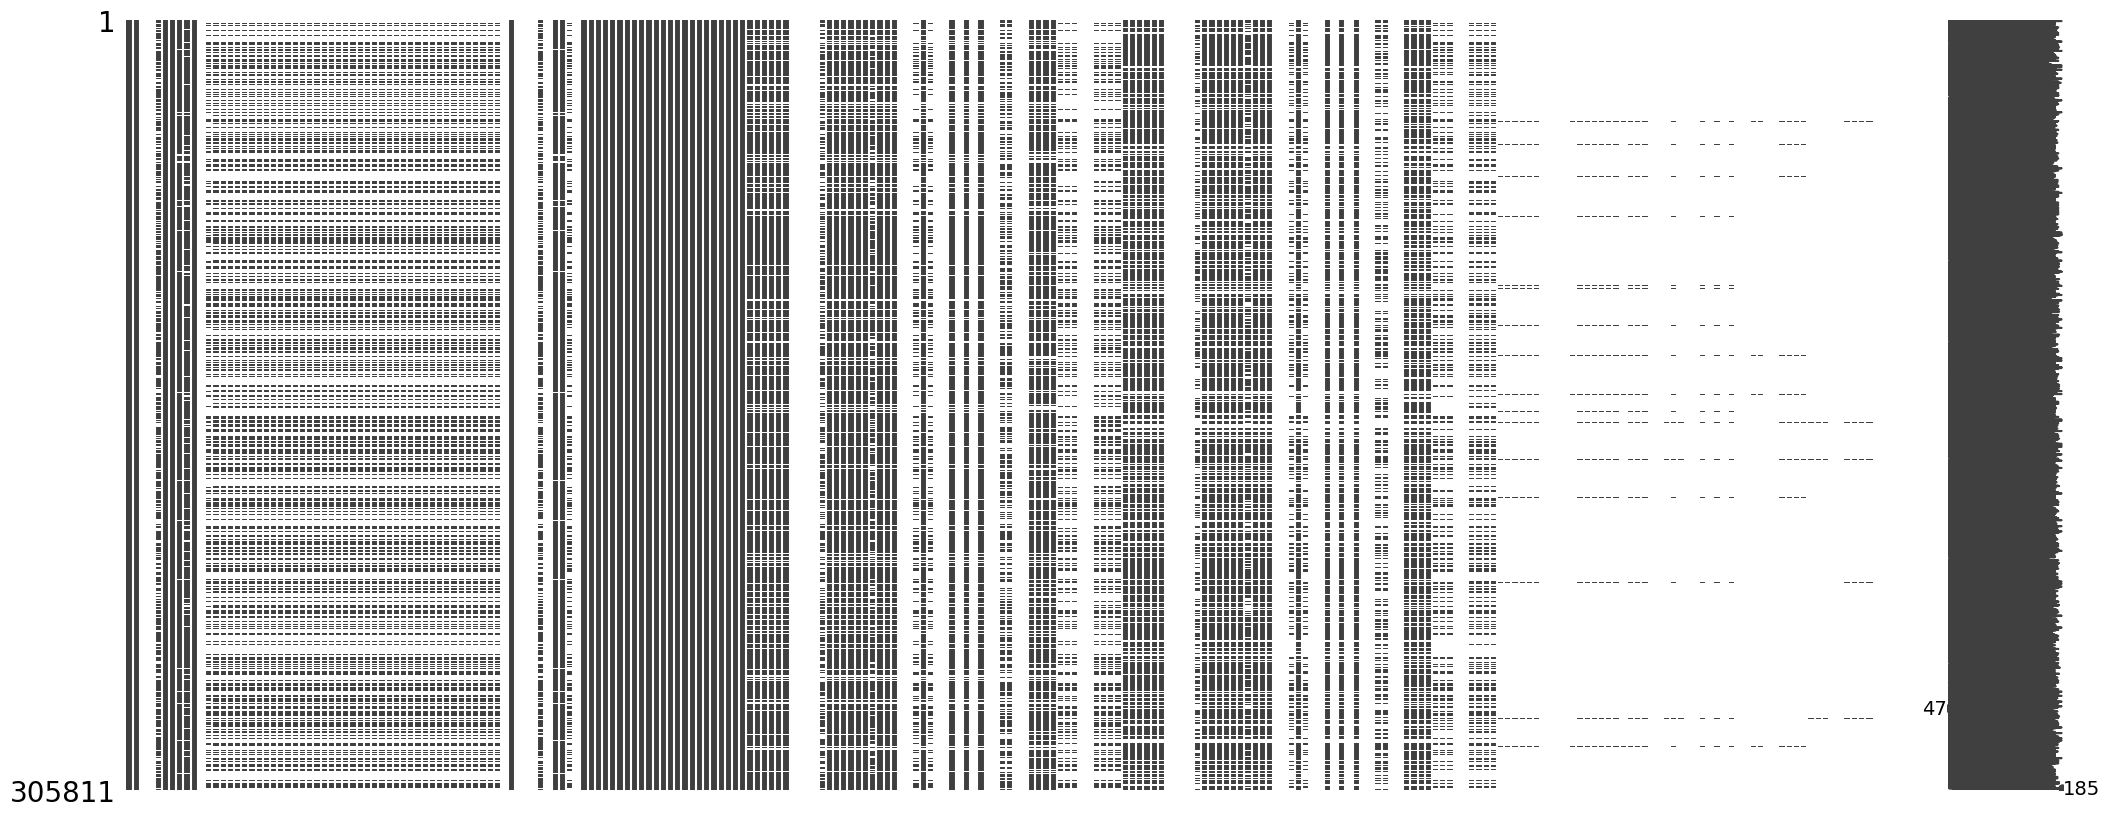

In [52]:
msno.matrix(bureau_merged_aggregated)

In [57]:
bureau_merged_aggregated = supprimer_colonnes_manquantes(bureau_merged_aggregated,0.5)
bureau_merged_aggregated.shape

(305811, 86)

### eda sur la table nouvellement crée

### PREVIOUS_APPLICATION

Ce tableau contient les données statiques relatives aux clients et à leurs crédits antérieurs auprès de Home Credit Group.

Tout d’abord, nous commençons par nettoyer les valeurs erronées. À partir de l’EDA, nous avons vu certains champs DAYS avec une valeur égale à 365243.0, ils semblent erronés, et nous allons donc les remplacer par des valeurs NaN.

Nous remplaçons les valeurs NaN des catégories par une catégorie 'XNA'.

Ensuite, nous procédons à l’ingénierie des fonctionnalités, où nous créons des fonctionnalités basées sur le domaine, telles que le ratio crédit-acompte, le montant non approuvé, le ratio crédit/marchandises, etc.

Nous essayons également de prédire le taux d’intérêt, en nous inspirant de l’un des articles des gagnants.

Pour pouvoir le fusionner avec la table principale, nous devons agréger les lignes de previous_application sur SK_ID_CURR. Nous effectuons des agrégations basées sur le domaine, sur tous les crédits précédents pour chaque client, tels que la moyenne, le maximum, le minimum, etc. Là encore, nous agrégeons de trois manières. Tout d’abord, nous effectuons l’agrégation globale, puis nous agrégeons pour les 2 premières applications et les 5 dernières applications. Le premier et le dernier sont décidés par le DAYS_FIRST_DUE des candidatures. En fin de compte, nous fusionnons toutes ces agrégations.

In [59]:
previous_application = pd.read_csv('data/previous_application.csv')

In [60]:
previous_application.shape

(1670214, 37)

In [61]:
#sorting the applications from oldest to most recent previous loans for each user
previous_application = previous_application.sort_values(by = ['SK_ID_CURR','DAYS_FIRST_DUE'])        

In [62]:
#in the EDA we found some erroneous values in DAYS columns, so we will replace them with NaN values
previous_application['DAYS_FIRST_DRAWING'][previous_application['DAYS_FIRST_DRAWING'] == 365243.0] = np.nan
previous_application['DAYS_FIRST_DUE'][previous_application['DAYS_FIRST_DUE'] == 365243.0] = np.nan
previous_application['DAYS_LAST_DUE_1ST_VERSION'][previous_application['DAYS_LAST_DUE_1ST_VERSION'] == 365243.0] = np.nan
previous_application['DAYS_LAST_DUE'][previous_application['DAYS_LAST_DUE'] == 365243.0] = np.nan
previous_application['DAYS_TERMINATION'][previous_application['DAYS_TERMINATION'] == 365243.0] = np.nan
#we also see abruptly large value for SELLERPLACE_AREA
previous_application['SELLERPLACE_AREA'][previous_application['SELLERPLACE_AREA'] == 4000000] = np.nan
#filling the NaN values for categories
categorical_columns = previous_application.dtypes[previous_application.dtypes == 'object'].index.tolist()
previous_application[categorical_columns] = previous_application[categorical_columns].fillna('XNA')
        

In [63]:
#label encoding the categorical variables
name_contract_dict = {'Approved': 0, 'Refused' : 3, 'Canceled' : 2, 'Unused offer' : 1}
previous_application['NAME_CONTRACT_STATUS'] = previous_application['NAME_CONTRACT_STATUS'].map(name_contract_dict)
yield_group_dict = {'XNA': 0, 'low_action': 1, 'low_normal': 2,'middle': 3, 'high': 4}
previous_application['NAME_YIELD_GROUP'] = previous_application['NAME_YIELD_GROUP'].map(yield_group_dict)
appl_per_contract_last_dict = {'Y':1, 'N':0}
previous_application['FLAG_LAST_APPL_PER_CONTRACT'] = previous_application['FLAG_LAST_APPL_PER_CONTRACT'].map(appl_per_contract_last_dict)
remaining_categorical_columns = previous_application.dtypes[previous_application.dtypes == 'object'].index.tolist()
for col in remaining_categorical_columns:
    encoding_dict = dict([(j,i) for i,j in enumerate(previous_application[col].unique(),1)])
    previous_application[col] = previous_application[col].map(encoding_dict)    


In [64]:
#engineering some features on domain knowledge
previous_application['MISSING_VALUES_TOTAL_PREV'] = previous_application.isna().sum(axis = 1)
previous_application['AMT_DECLINED'] = previous_application['AMT_APPLICATION'] - previous_application['AMT_CREDIT']
previous_application['AMT_CREDIT_GOODS_RATIO'] = previous_application['AMT_CREDIT'] / (previous_application['AMT_GOODS_PRICE'] + 0.00001)
previous_application['AMT__CREDIT_GOODS_DIFF'] = previous_application['AMT_CREDIT'] - previous_application['AMT_GOODS_PRICE']
previous_application['AMT_CREDIT_APPLICATION_RATIO'] = previous_application['AMT_APPLICATION'] / (previous_application['AMT_CREDIT'] + 0.00001)
previous_application['CREDIT_DOWNPAYMENT_RATIO'] = previous_application['AMT_DOWN_PAYMENT'] / (previous_application['AMT_CREDIT'] + 0.00001)
previous_application['GOOD_DOWNPAYMET_RATIO'] = previous_application['AMT_DOWN_PAYMENT'] / (previous_application['AMT_GOODS_PRICE'] + 0.00001)
previous_application['INTEREST_DOWNPAYMENT'] = previous_application['RATE_DOWN_PAYMENT'] * previous_application['AMT_DOWN_PAYMENT']
previous_application['INTEREST_CREDIT'] = previous_application['AMT_CREDIT'] * previous_application['RATE_INTEREST_PRIMARY']
previous_application['INTEREST_CREDIT_PRIVILEGED'] = previous_application['AMT_CREDIT'] * previous_application['RATE_INTEREST_PRIVILEGED']
previous_application['APPLICATION_AMT_TO_DECISION_RATIO'] = previous_application['AMT_APPLICATION'] / (previous_application['DAYS_DECISION'] + 0.00001) * -1
previous_application['AMT_APPLICATION_TO_SELLERPLACE_AREA'] = previous_application['AMT_APPLICATION'] / (previous_application['SELLERPLACE_AREA'] + 0.00001)
previous_application['ANNUITY'] = previous_application['AMT_CREDIT'] / (previous_application['CNT_PAYMENT'] + 0.00001)
previous_application['ANNUITY_GOODS'] = previous_application['AMT_GOODS_PRICE'] / (previous_application['CNT_PAYMENT'] + 0.00001)
previous_application['DAYS_FIRST_LAST_DUE_DIFF' ] = previous_application['DAYS_LAST_DUE'] - previous_application['DAYS_FIRST_DUE']
previous_application['AMT_CREDIT_HOUR_PROCESS_START'] = previous_application['AMT_CREDIT'] * previous_application['HOUR_APPR_PROCESS_START']
previous_application['AMT_CREDIT_NFLAG_LAST_APPL_DAY'] = previous_application['AMT_CREDIT'] * previous_application['NFLAG_LAST_APPL_IN_DAY']
previous_application['AMT_CREDIT_YIELD_GROUP'] = previous_application['AMT_CREDIT'] * previous_application['NAME_YIELD_GROUP']
#https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
previous_application['AMT_INTEREST'] = previous_application['CNT_PAYMENT'] * previous_application['AMT_ANNUITY'] - previous_application['AMT_CREDIT'] 
previous_application['INTEREST_SHARE'] = previous_application['AMT_INTEREST'] / (previous_application['AMT_CREDIT'] + 0.00001)
previous_application['INTEREST_RATE'] = 2 * 12 * previous_application['AMT_INTEREST'] / (previous_application['AMT_CREDIT'] * (previous_application['CNT_PAYMENT'] + 1))


In [65]:
aggregations_for_previous_application = {
            'MISSING_VALUES_TOTAL_PREV' : ['sum'],
            'NAME_CONTRACT_TYPE' : ['mean','last'],
            'AMT_ANNUITY' : ['mean','sum','max'],
            'AMT_APPLICATION' : ['mean','max','sum'],
            'AMT_CREDIT' : ['mean','max','sum'],
            'AMT_DOWN_PAYMENT' : ['mean','max','sum'],
            'AMT_GOODS_PRICE' : ['mean','max','sum'],
            'WEEKDAY_APPR_PROCESS_START' : ['mean','max','min'],
            'HOUR_APPR_PROCESS_START' : ['mean','max','min'],
            'FLAG_LAST_APPL_PER_CONTRACT' : ['mean','sum'],
            'NFLAG_LAST_APPL_IN_DAY' : ['mean','sum'],
            'RATE_DOWN_PAYMENT' : ['mean','max'],
            'RATE_INTEREST_PRIMARY' : ['mean','max'],
            'RATE_INTEREST_PRIVILEGED' : ['mean','max'],
            'NAME_CASH_LOAN_PURPOSE' : ['mean','last'],
            'NAME_CONTRACT_STATUS' : ['mean','max','last'],
            'DAYS_DECISION' : ['mean','max','min'],
            'NAME_PAYMENT_TYPE' : ['mean', 'last'],
            'CODE_REJECT_REASON' : ['mean','last'],
            'NAME_TYPE_SUITE' : ['mean','last'],
            'NAME_CLIENT_TYPE' : ['mean','last'],
            'NAME_GOODS_CATEGORY' : ['mean','last'],
            'NAME_PORTFOLIO' : ['mean','last'],
            'NAME_PRODUCT_TYPE' : ['mean','last'],
            'CHANNEL_TYPE' : ['mean','last'],
            'SELLERPLACE_AREA' : ['mean','max','min'],
            'NAME_SELLER_INDUSTRY' : ['mean','last'],
            'CNT_PAYMENT' : ['sum','mean','max'],
            'NAME_YIELD_GROUP' : ['mean','last'],
            'PRODUCT_COMBINATION' : ['mean', 'last'],
            'DAYS_FIRST_DRAWING' : ['mean','max'],
            'DAYS_FIRST_DUE' : ['mean','max'],
            'DAYS_LAST_DUE_1ST_VERSION' : ['mean'],
            'DAYS_LAST_DUE' : ['mean'],
            'DAYS_TERMINATION' : ['mean','max'],
            'NFLAG_INSURED_ON_APPROVAL' : ['sum'],
            'AMT_DECLINED' : ['mean','max','sum'],
            'AMT_CREDIT_GOODS_RATIO' : ['mean', 'max', 'min'],
            #'AMT_CREDIT_GOODS_DIFF' : ['sum','mean','max', 'min'],
            'AMT_CREDIT_APPLICATION_RATIO' : ['mean','min'],
            'CREDIT_DOWNPAYMENT_RATIO' : ['mean','max'],
            'GOOD_DOWNPAYMET_RATIO' : ['mean','max'],
            'INTEREST_DOWNPAYMENT' : ['mean','sum','max'],
            'INTEREST_CREDIT' : ['mean','sum','max'],
            'INTEREST_CREDIT_PRIVILEGED' : ['mean','sum','max'],
            'APPLICATION_AMT_TO_DECISION_RATIO' : ['mean','min'],
            'AMT_APPLICATION_TO_SELLERPLACE_AREA' : ['mean','max'],
            'ANNUITY' : ['mean','sum','max'],
            'ANNUITY_GOODS' : ['mean','sum','max'],
            'DAYS_FIRST_LAST_DUE_DIFF' : ['mean','max'],
            'AMT_CREDIT_HOUR_PROCESS_START' : ['mean','sum'],
            'AMT_CREDIT_NFLAG_LAST_APPL_DAY' : ['mean','max'],
            'AMT_CREDIT_YIELD_GROUP' : ['mean','sum','min'],
            'AMT_INTEREST' : ['mean','sum','max','min'],
            'INTEREST_SHARE' : ['mean','max','min'],
            'INTEREST_RATE' : ['mean','max','min']
        }

In [66]:
#grouping the previous applications over SK_ID_CURR while only taking the latest 5 applications
group_last_3 = previous_application.groupby('SK_ID_CURR').tail(5).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
group_last_3.columns = ['_'.join(ele).upper() + '_LAST_5' for ele in group_last_3.columns]
        

In [67]:
#grouping the previous applications over SK_ID_CURR while only taking the first 2 applications
group_first_3 = previous_application.groupby('SK_ID_CURR').head(2).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
group_first_3.columns = ['_'.join(ele).upper() + '_FIRST_2' for ele in group_first_3.columns]
        

In [68]:
#grouping the previous applications over SK_ID_CURR while taking all the applications into consideration
group_all = previous_application.groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
group_all.columns = ['_'.join(ele).upper() + '_ALL' for ele in group_all.columns]


In [69]:

#merging all the applications
previous_application_aggregated = group_last_3.merge(group_first_3, on = 'SK_ID_CURR', how = 'outer')
previous_application_aggregated = previous_application_aggregated.merge(group_all, on = 'SK_ID_CURR', how = 'outer')


In [71]:
previous_application_aggregated.shape

(338857, 387)

<Axes: >

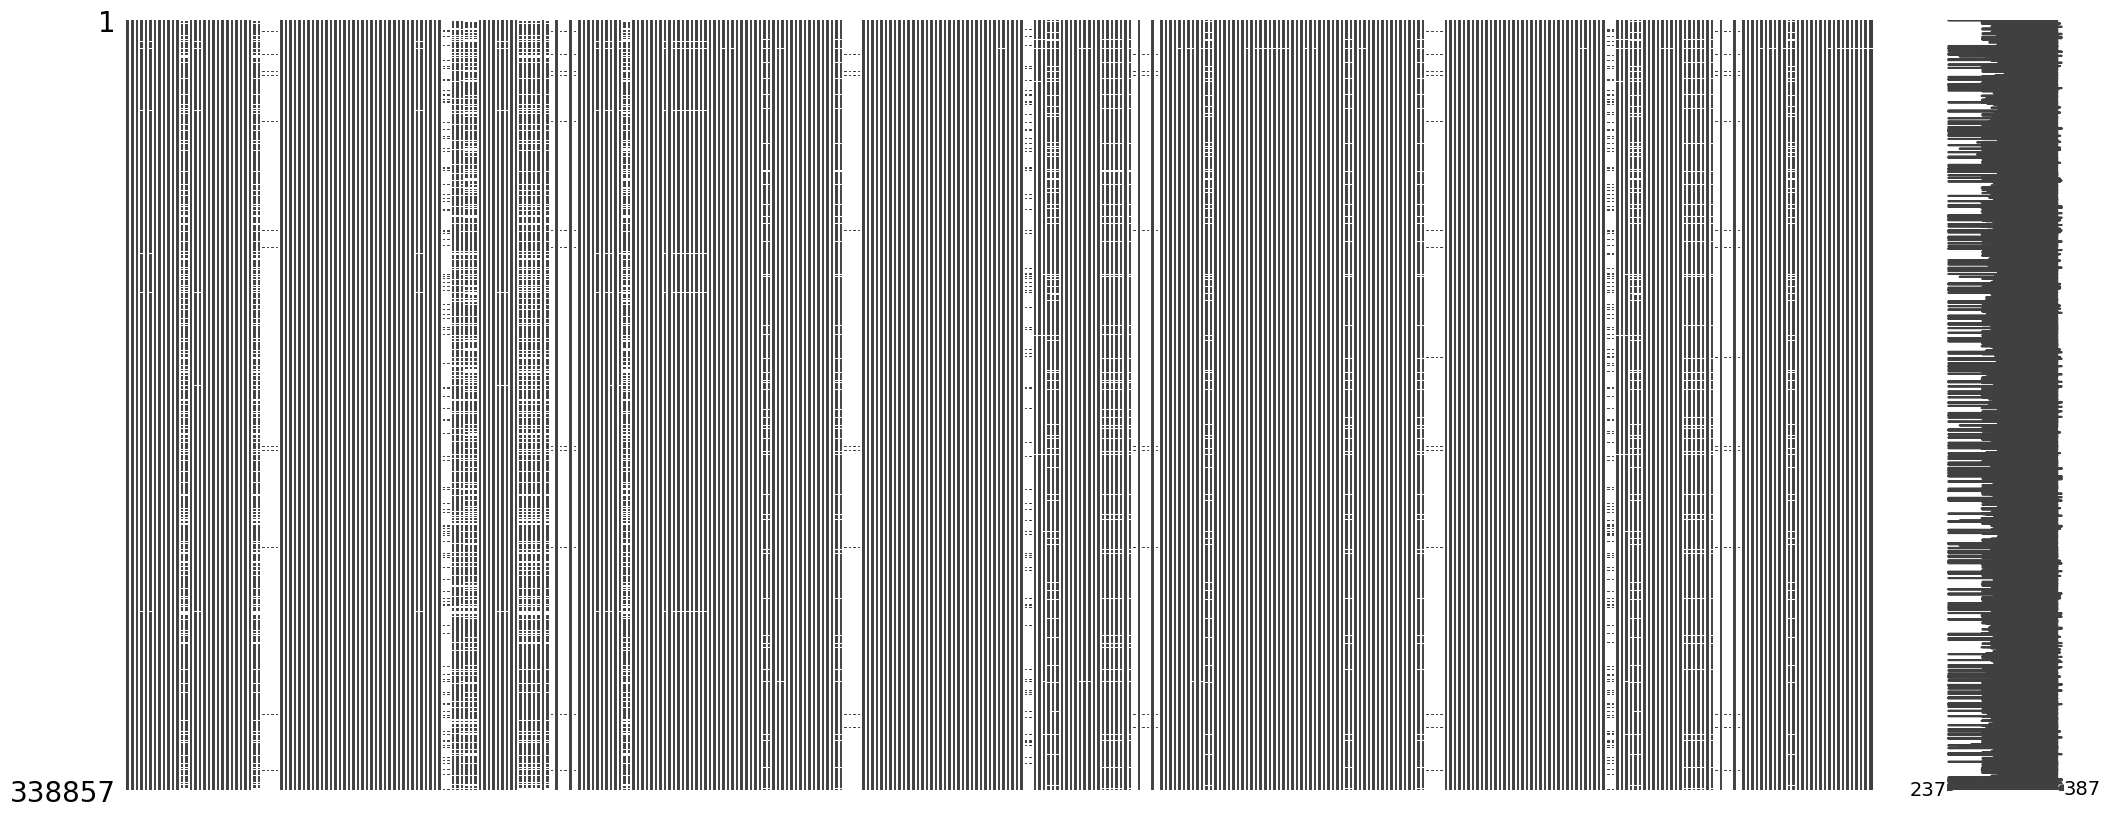

In [70]:
msno.matrix(previous_application_aggregated)

In [78]:
previous_application_aggregated = supprimer_colonnes_manquantes(previous_application_aggregated, 0.001)
print(previous_application_aggregated.shape,A.shape)

(338857, 387) (338857, 237)


<Axes: >

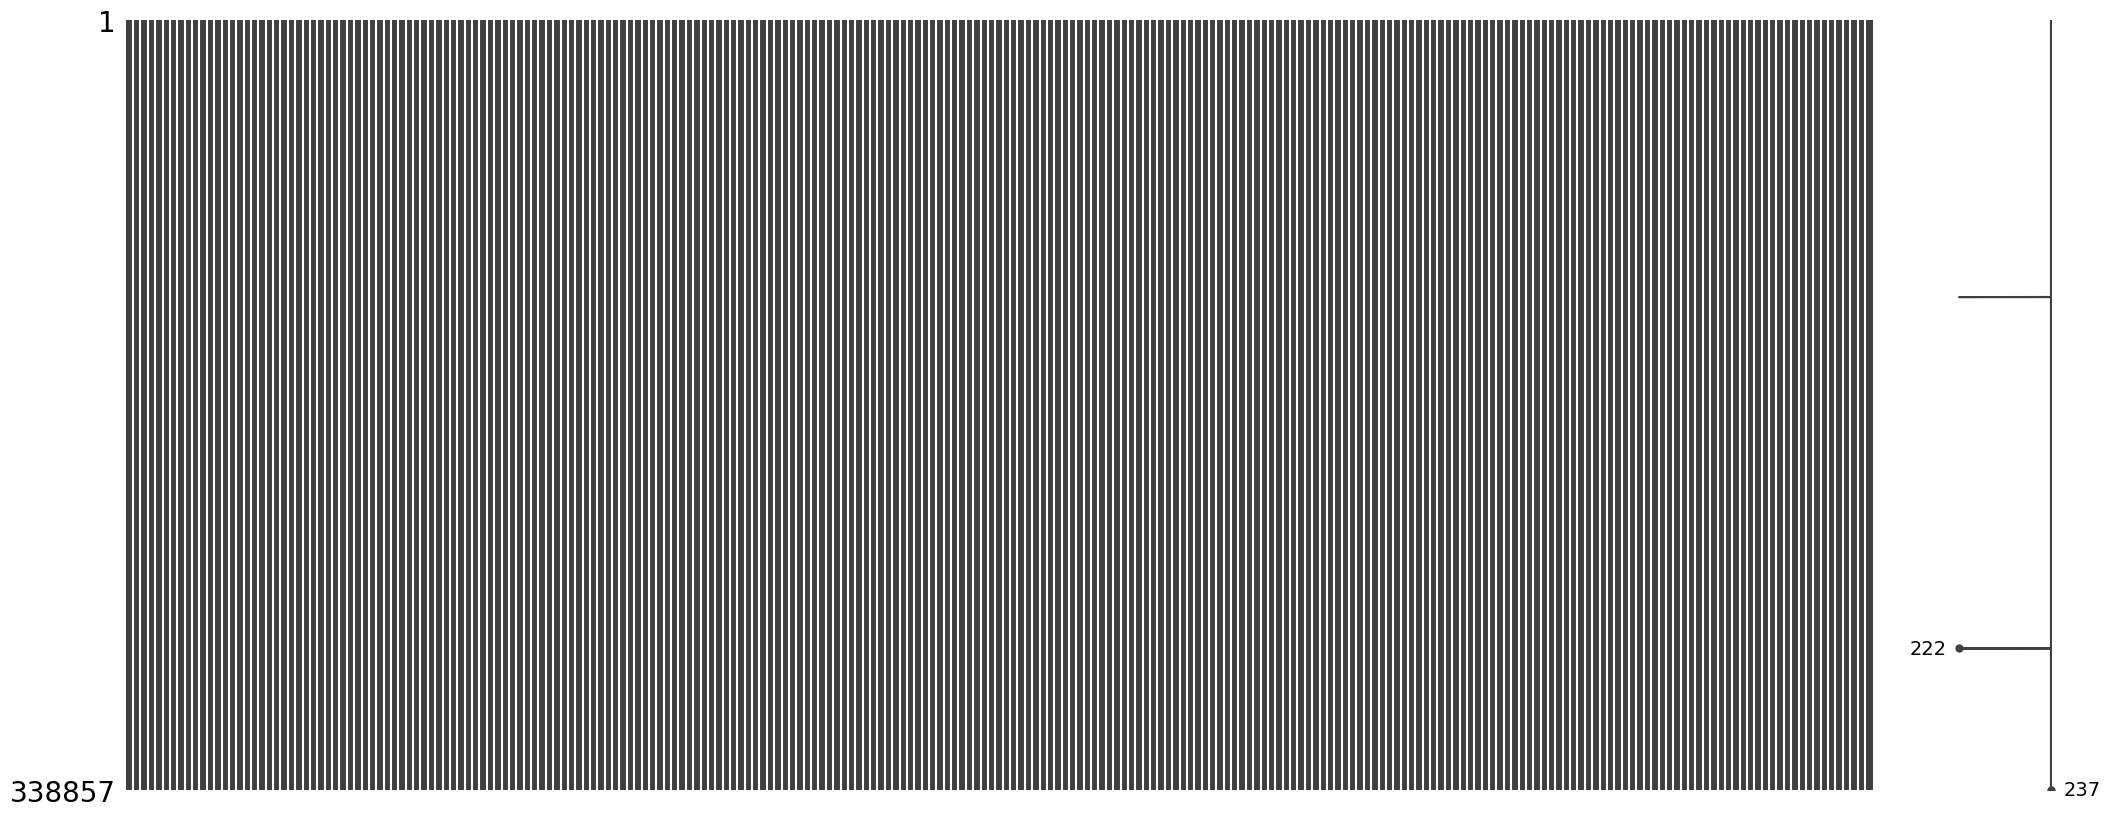

In [79]:
msno.matrix(previous_application_aggregated)

### application train et test

Ces tableaux sont constitués de données statiques relatives aux Emprunteurs. Chaque ligne représente une demande de prêt.

Tout d’abord, nous commençons par nettoyer les données en supprimant les points de données erronés. Nous supprimons également les lignes dans les données d’apprentissage avec des catégories de sorte que ces catégories n’apparaissent pas dans les données de test. Nous convertissons également les caractéristiques d’évaluation de la région en caractéristiques catégorielles, car nous avons vu dans l’EDA qu’elles ne suivent pas un comportement ordinal en ce qui concerne les caractéristiques par défaut.

En nous inspirant de l’article du gagnant pour le problème, nous prédisons également les valeurs manquantes des caractéristiques de EXT_SOURCE en construisant un modèle de régression sur le reste des caractéristiques numériques.

Ensuite, nous effectuons l’ingénierie des caractéristiques sur les caractéristiques numériques et générons des caractéristiques basées sur la connaissance du domaine, telles que le ratio REVENU / RENTE, EXT_SOURCE moyennes, etc.

Nous essayons également de prédire les taux d’intérêt en utilisant les données des fonctionnalités des applications précédentes, et en prédisant en utilisant les données de application_train fonctionnalités. Nous créons également une entité basée sur les valeurs Target à partir de application_train où nous calculons la moyenne des cibles de 500 voisins les plus proches de chaque ligne.

Ensuite, nous créons des caractéristiques basées sur les interactions catégorielles en regroupant les données sur plusieurs combinaisons catégorielles et en imputant les agrégats de chaque groupe en tant qu’entités.

Nous encodons les caractéristiques catégorielles par codage de réponse, car nous ne voulions pas augmenter la dimensionnalité de plusieurs fois en utilisant OHE.

In [31]:
application_train = pd.read_csv('data/application_train.csv')
application_test = pd.read_csv('data/application_test.csv')

In [32]:
flag_cols_to_drop = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12',
                            'FLAG_DOCUMENT_20']

In [33]:
application_train = application_train.drop(flag_cols_to_drop, axis = 1)
application_test = application_test.drop(flag_cols_to_drop, axis = 1)
#converting age from days to years
application_train['DAYS_BIRTH'] = application_train['DAYS_BIRTH'] * -1 / 365
application_test['DAYS_BIRTH'] = application_test['DAYS_BIRTH'] * -1 / 365
        

In [34]:
#From the EDA we saw some erroneous values in DAYS_EMPLOYED field
application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED'] == 365243] = np.nan
application_test['DAYS_EMPLOYED'][application_test['DAYS_EMPLOYED'] == 365243] = np.nan
        

In [35]:
#OBS Columns have an erroneous value, we'll remove those values
application_train['OBS_30_CNT_SOCIAL_CIRCLE'][application_train['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
application_train['OBS_60_CNT_SOCIAL_CIRCLE'][application_train['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
application_test['OBS_30_CNT_SOCIAL_CIRCLE'][application_test['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
application_test['OBS_60_CNT_SOCIAL_CIRCLE'][application_test['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan


37465    False
38869    False
39671    False
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: bool

In [36]:
#there were also 4 rows with 'XNA' as Gender, removing these rows
application_train = application_train[application_train['CODE_GENDER'] != 'XNA']
#filling the categorical columns with 'XNA' value
categorical_columns = application_train.dtypes[application_train.dtypes == 'object'].index.tolist()
application_train[categorical_columns] = application_train[categorical_columns].fillna('XNA')
application_test[categorical_columns] = application_test[categorical_columns].fillna('XNA')
       

In [37]:
#converting columns of REGION_RATING_CLIENT to object type, as we saw some complex impact on TARGET variable during EDA
application_train['REGION_RATING_CLIENT'] = application_train['REGION_RATING_CLIENT'].astype('object')
application_train['REGION_RATING_CLIENT_W_CITY'] = application_train['REGION_RATING_CLIENT_W_CITY'].astype('object')
application_test['REGION_RATING_CLIENT'] = application_test['REGION_RATING_CLIENT'].astype('object')
application_test['REGION_RATING_CLIENT_W_CITY'] = application_test['REGION_RATING_CLIENT_W_CITY'].astype('object')
#counting the total NaN values for each application
application_train['MISSING_VALS_TOTAL_APP'] = application_train.isna().sum(axis = 1)
application_test['MISSING_VALS_TOTAL_APP'] = application_test.isna().sum(axis = 1)


In [38]:
application_train['CREDIT_INCOME_RATIO'] = application_train['AMT_CREDIT'] / (application_train['AMT_INCOME_TOTAL'] + 0.00001)
application_train['CREDIT_ANNUITY_RATIO'] = application_train['AMT_CREDIT'] / (application_train['AMT_ANNUITY'] + 0.00001)
application_train['ANNUITY_INCOME_RATIO'] = application_train['AMT_ANNUITY'] / (application_train['AMT_INCOME_TOTAL'] + 0.00001)
application_train['INCOME_ANNUITY_DIFF'] = application_train['AMT_INCOME_TOTAL'] - application_train['AMT_ANNUITY']
application_train['CREDIT_GOODS_RATIO'] = application_train['AMT_CREDIT'] / (application_train['AMT_GOODS_PRICE'] + 0.00001)
application_train['CREDIT_GOODS_DIFF'] = application_train['AMT_CREDIT'] - application_train['AMT_GOODS_PRICE'] + 0.00001
application_train['GOODS_INCOME_RATIO'] = application_train['AMT_GOODS_PRICE'] / (application_train['AMT_INCOME_TOTAL'] + 0.00001)
application_train['INCOME_EXT_RATIO'] = application_train['AMT_INCOME_TOTAL'] / (application_train['EXT_SOURCE_3'] + 0.00001)
application_train['CREDIT_EXT_RATIO'] = application_train['AMT_CREDIT'] / (application_train['EXT_SOURCE_3'] + 0.00001)
#age ratios and diffs
application_train['AGE_EMPLOYED_DIFF'] = application_train['DAYS_BIRTH'] - application_train['DAYS_EMPLOYED']
application_train['EMPLOYED_TO_AGE_RATIO'] = application_train['DAYS_EMPLOYED'] / (application_train['DAYS_BIRTH'] + 0.00001)
#car ratios
application_train['CAR_EMPLOYED_DIFF'] = application_train['OWN_CAR_AGE'] - application_train['DAYS_EMPLOYED']
application_train['CAR_EMPLOYED_RATIO'] = application_train['OWN_CAR_AGE'] / (application_train['DAYS_EMPLOYED']+0.00001)
application_train['CAR_AGE_DIFF'] = application_train['DAYS_BIRTH'] - application_train['OWN_CAR_AGE']
application_train['CAR_AGE_RATIO'] = application_train['OWN_CAR_AGE'] / (application_train['DAYS_BIRTH'] + 0.00001)
#flag contacts sum
application_train['FLAG_CONTACTS_SUM'] = application_train['FLAG_MOBIL'] + application_train['FLAG_EMP_PHONE'] + application_train['FLAG_WORK_PHONE'] + application_train[
                            'FLAG_CONT_MOBILE'] + application_train['FLAG_PHONE'] + application_train['FLAG_EMAIL']



application_train['HOUR_PROCESS_CREDIT_MUL'] = application_train['AMT_CREDIT'] * application_train['HOUR_APPR_PROCESS_START']
#family members
application_train['CNT_NON_CHILDREN'] = application_train['CNT_FAM_MEMBERS'] - application_train['CNT_CHILDREN']
application_train['CHILDREN_INCOME_RATIO'] = application_train['CNT_CHILDREN'] / (application_train['AMT_INCOME_TOTAL'] + 0.00001)
application_train['PER_CAPITA_INCOME'] = application_train['AMT_INCOME_TOTAL'] / (application_train['CNT_FAM_MEMBERS'] + 1)
#region ratings
application_train['REGIONS_RATING_INCOME_MUL'] = (application_train['REGION_RATING_CLIENT'] + application_train['REGION_RATING_CLIENT_W_CITY']) * application_train['AMT_INCOME_TOTAL'] / 2
application_train['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(application_train['REGION_RATING_CLIENT'], application_train['REGION_RATING_CLIENT_W_CITY'])]
application_train['REGION_RATING_MAX'] = [min(ele1, ele2) for ele1, ele2 in zip(application_train['REGION_RATING_CLIENT'], application_train['REGION_RATING_CLIENT_W_CITY'])]
application_train['REGION_RATING_MEAN'] = (application_train['REGION_RATING_CLIENT'] + application_train['REGION_RATING_CLIENT_W_CITY']) / 2
application_train['REGION_RATING_MUL'] = application_train['REGION_RATING_CLIENT'] * application_train['REGION_RATING_CLIENT_W_CITY']
#flag regions
application_train['FLAG_REGIONS'] = application_train['REG_REGION_NOT_LIVE_REGION'] + application_train['REG_REGION_NOT_WORK_REGION'] + application_train['LIVE_REGION_NOT_WORK_REGION']+application_train[
                        'REG_CITY_NOT_LIVE_CITY'] + application_train['REG_CITY_NOT_WORK_CITY'] + application_train['LIVE_CITY_NOT_WORK_CITY']   
#ext_sources
application_train['EXT_SOURCE_MEAN'] = (application_train['EXT_SOURCE_1'] + application_train['EXT_SOURCE_2'] + application_train['EXT_SOURCE_3'] ) / 3
application_train['EXT_SOURCE_MUL'] = application_train['EXT_SOURCE_1'] * application_train['EXT_SOURCE_2'] * application_train['EXT_SOURCE_3'] 
application_train['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(application_train['EXT_SOURCE_1'], application_train['EXT_SOURCE_2'], application_train['EXT_SOURCE_3'])]
application_train['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(application_train['EXT_SOURCE_1'], application_train['EXT_SOURCE_2'], application_train['EXT_SOURCE_3'])]
application_train['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(application_train['EXT_SOURCE_1'], application_train['EXT_SOURCE_2'], application_train['EXT_SOURCE_3'])]
application_train['WEIGHTED_EXT_SOURCE'] =  application_train.EXT_SOURCE_1 * 2 + application_train.EXT_SOURCE_2 * 3 + application_train.EXT_SOURCE_3 * 4
#apartment scores
application_train['APARTMENTS_SUM_AVG'] = application_train['APARTMENTS_AVG'] + application_train['BASEMENTAREA_AVG'] + application_train['YEARS_BEGINEXPLUATATION_AVG'] + application_train[
                            'YEARS_BUILD_AVG'] + application_train['COMMONAREA_AVG'] + application_train['ELEVATORS_AVG'] + application_train['ENTRANCES_AVG'] + application_train[
                            'FLOORSMAX_AVG'] + application_train['FLOORSMIN_AVG'] + application_train['LANDAREA_AVG'] + application_train['LIVINGAPARTMENTS_AVG'] + application_train[
                            'LIVINGAREA_AVG'] + application_train['NONLIVINGAPARTMENTS_AVG'] + application_train['NONLIVINGAREA_AVG']
application_train['APARTMENTS_SUM_MODE'] = application_train['APARTMENTS_MODE'] + application_train['BASEMENTAREA_MODE'] + application_train['YEARS_BEGINEXPLUATATION_MODE'] + application_train[
                            'YEARS_BUILD_MODE'] + application_train['COMMONAREA_MODE'] + application_train['ELEVATORS_MODE'] + application_train['ENTRANCES_MODE'] + application_train[
                            'FLOORSMAX_MODE'] + application_train['FLOORSMIN_MODE'] + application_train['LANDAREA_MODE'] + application_train['LIVINGAPARTMENTS_MODE'] + application_train[
                            'LIVINGAREA_MODE'] + application_train['NONLIVINGAPARTMENTS_MODE'] + application_train['NONLIVINGAREA_MODE'] + application_train['TOTALAREA_MODE']
application_train['APARTMENTS_SUM_MEDI'] = application_train['APARTMENTS_MEDI'] + application_train['BASEMENTAREA_MEDI'] + application_train['YEARS_BEGINEXPLUATATION_MEDI'] + application_train[
                            'YEARS_BUILD_MEDI'] + application_train['COMMONAREA_MEDI'] + application_train['ELEVATORS_MEDI'] + application_train['ENTRANCES_MEDI'] + application_train[
                            'FLOORSMAX_MEDI'] + application_train['FLOORSMIN_MEDI'] + application_train['LANDAREA_MEDI'] + application_train['LIVINGAPARTMENTS_MEDI'] + application_train[
                            'LIVINGAREA_MEDI'] + application_train['NONLIVINGAPARTMENTS_MEDI'] + application_train['NONLIVINGAREA_MEDI']
application_train['INCOME_APARTMENT_AVG_MUL'] = application_train['APARTMENTS_SUM_AVG'] * application_train['AMT_INCOME_TOTAL']
application_train['INCOME_APARTMENT_MODE_MUL'] = application_train['APARTMENTS_SUM_MODE'] * application_train['AMT_INCOME_TOTAL']
application_train['INCOME_APARTMENT_MEDI_MUL'] = application_train['APARTMENTS_SUM_MEDI'] * application_train['AMT_INCOME_TOTAL']
#OBS And DEF
application_train['OBS_30_60_SUM'] = application_train['OBS_30_CNT_SOCIAL_CIRCLE'] + application_train['OBS_60_CNT_SOCIAL_CIRCLE']
application_train['DEF_30_60_SUM'] = application_train['DEF_30_CNT_SOCIAL_CIRCLE'] + application_train['DEF_60_CNT_SOCIAL_CIRCLE']
application_train['OBS_DEF_30_MUL'] = application_train['OBS_30_CNT_SOCIAL_CIRCLE'] *  application_train['DEF_30_CNT_SOCIAL_CIRCLE']
application_train['OBS_DEF_60_MUL'] = application_train['OBS_60_CNT_SOCIAL_CIRCLE'] *  application_train['DEF_60_CNT_SOCIAL_CIRCLE']
application_train['SUM_OBS_DEF_ALL'] = application_train['OBS_30_CNT_SOCIAL_CIRCLE'] + application_train['DEF_30_CNT_SOCIAL_CIRCLE'] + application_train[
                            'OBS_60_CNT_SOCIAL_CIRCLE'] + application_train['DEF_60_CNT_SOCIAL_CIRCLE']
application_train['OBS_30_CREDIT_RATIO'] = application_train['AMT_CREDIT'] / (application_train['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
application_train['OBS_60_CREDIT_RATIO'] = application_train['AMT_CREDIT'] / (application_train['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
application_train['DEF_30_CREDIT_RATIO'] = application_train['AMT_CREDIT'] / (application_train['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
application_train['DEF_60_CREDIT_RATIO'] = application_train['AMT_CREDIT'] / (application_train['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
#Flag Documents combined
application_train['SUM_FLAGS_DOCUMENTS'] = application_train['FLAG_DOCUMENT_3'] + application_train['FLAG_DOCUMENT_5'] + application_train['FLAG_DOCUMENT_6']  + application_train[
                            'FLAG_DOCUMENT_7'] + application_train['FLAG_DOCUMENT_8'] + application_train['FLAG_DOCUMENT_9'] + application_train[
                            'FLAG_DOCUMENT_11'] + application_train['FLAG_DOCUMENT_13'] + application_train['FLAG_DOCUMENT_14'] + application_train[
                            'FLAG_DOCUMENT_15'] + application_train['FLAG_DOCUMENT_16'] + application_train['FLAG_DOCUMENT_17'] + application_train[
                            'FLAG_DOCUMENT_18'] + application_train['FLAG_DOCUMENT_19'] + application_train['FLAG_DOCUMENT_21']
#details change
application_train['DAYS_DETAILS_CHANGE_MUL'] = application_train['DAYS_LAST_PHONE_CHANGE'] * application_train['DAYS_REGISTRATION'] * application_train['DAYS_ID_PUBLISH']
application_train['DAYS_DETAILS_CHANGE_SUM'] = application_train['DAYS_LAST_PHONE_CHANGE'] + application_train['DAYS_REGISTRATION'] + application_train['DAYS_ID_PUBLISH']
#enquires
application_train['AMT_ENQ_SUM'] = application_train['AMT_REQ_CREDIT_BUREAU_HOUR'] + application_train['AMT_REQ_CREDIT_BUREAU_DAY'] + application_train['AMT_REQ_CREDIT_BUREAU_WEEK'] + application_train[
                    'AMT_REQ_CREDIT_BUREAU_MON'] + application_train['AMT_REQ_CREDIT_BUREAU_QRT'] + application_train['AMT_REQ_CREDIT_BUREAU_YEAR']
application_train['ENQ_CREDIT_RATIO'] = application_train['AMT_ENQ_SUM'] / (application_train['AMT_CREDIT'] + 0.00001)





In [39]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SUM_OBS_DEF_ALL,OBS_30_CREDIT_RATIO,OBS_60_CREDIT_RATIO,DEF_30_CREDIT_RATIO,DEF_60_CREDIT_RATIO,SUM_FLAGS_DOCUMENTS,DAYS_DETAILS_CHANGE_MUL,DAYS_DETAILS_CHANGE_SUM,AMT_ENQ_SUM,ENQ_CREDIT_RATIO
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,2.032977e+05,2.032977e+05,2.032977e+05,2.032977e+05,1,-8.770084e+09,-6902.0,1.0,0.000002
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,2.0,1.293490e+06,1.293490e+06,1.293502e+11,1.293502e+11,1,-2.857643e+08,-2305.0,0.0,0.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,1.350000e+10,1.350000e+10,1.350000e+10,1.350000e+10,0,-8.787379e+09,-7606.0,0.0,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,4.0,1.563405e+05,1.563405e+05,3.126825e+10,3.126825e+10,1,-1.478518e+10,-12887.0,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,5.130000e+10,5.130000e+10,5.130000e+10,5.130000e+10,1,-1.648763e+10,-8875.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0.0,2.547000e+10,2.547000e+10,2.547000e+10,2.547000e+10,1,-4.575423e+09,-10711.0,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0.0,2.695500e+10,2.695500e+10,2.695500e+10,2.695500e+10,1,0.000000e+00,-8478.0,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,12.0,1.129438e+05,1.129438e+05,6.776640e+10,6.776640e+10,1,-6.623380e+10,-13796.0,3.0,0.000004
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,3.701070e+10,3.701070e+10,3.701070e+10,3.701070e+10,1,-7.680415e+08,-3815.0,0.0,0.000000


<Axes: >

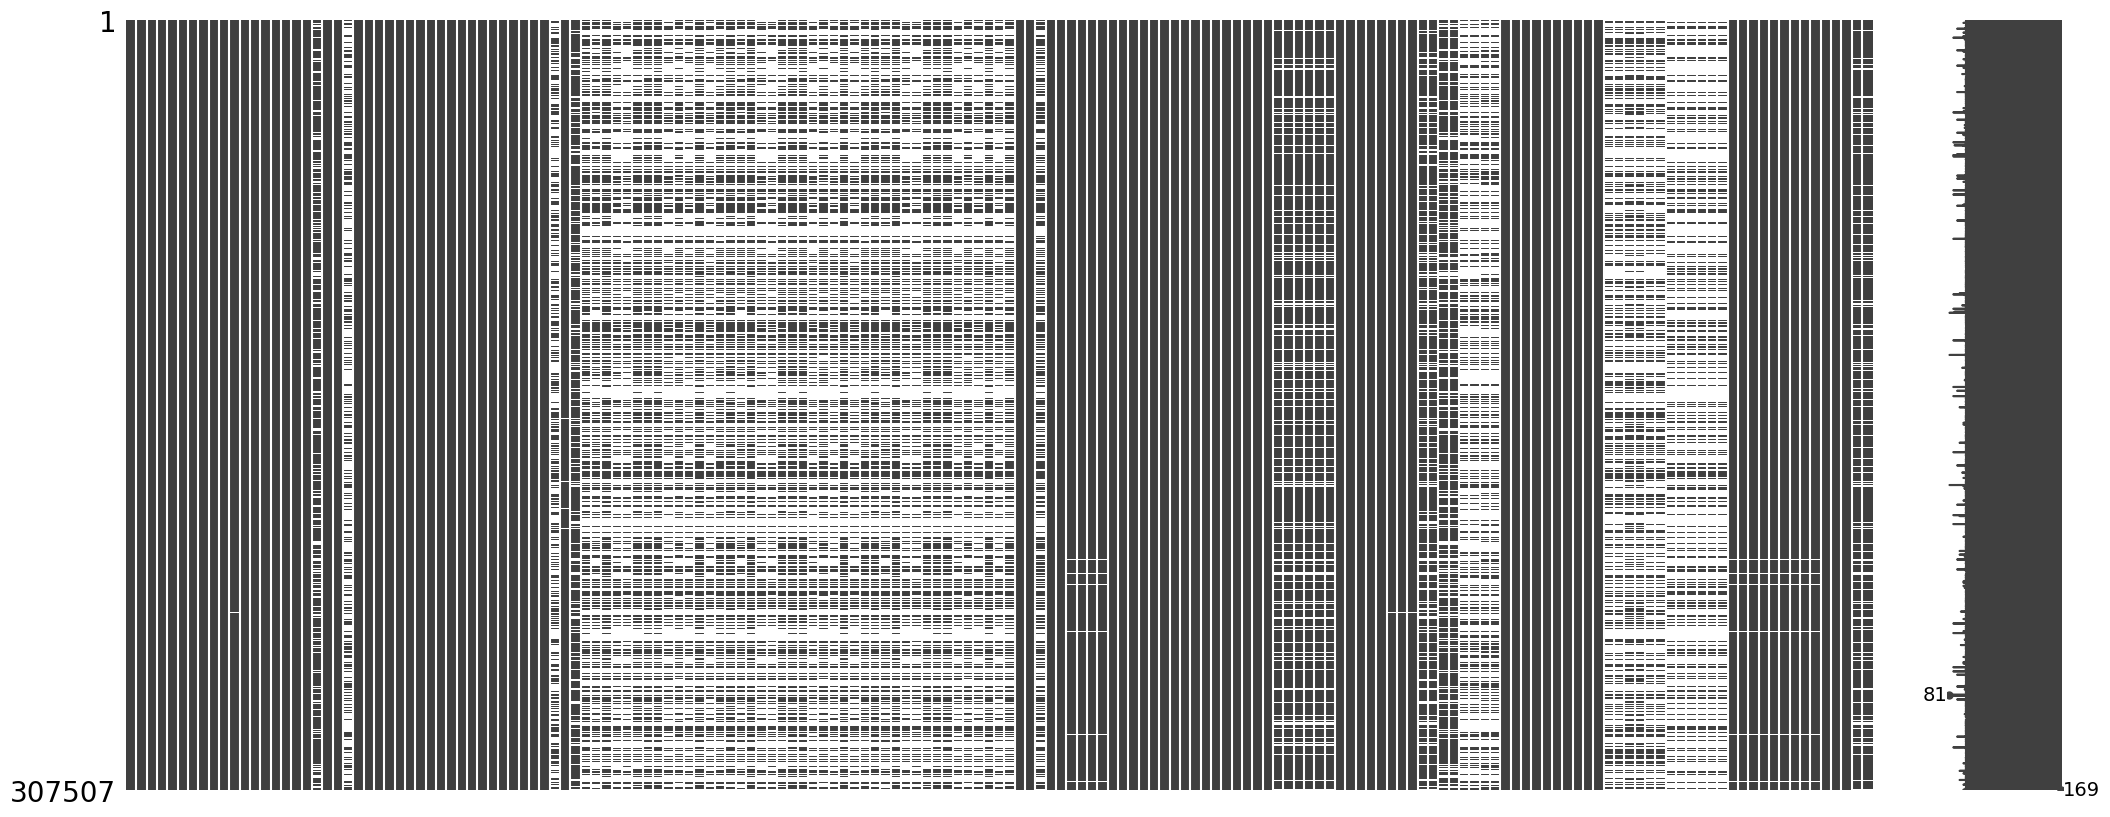

In [80]:
msno.matrix(application_train)

In [81]:
application_train_light = supprimer_colonnes_manquantes(application_train, 0.3)
application_train_light.shape

(307507, 108)

<Axes: >

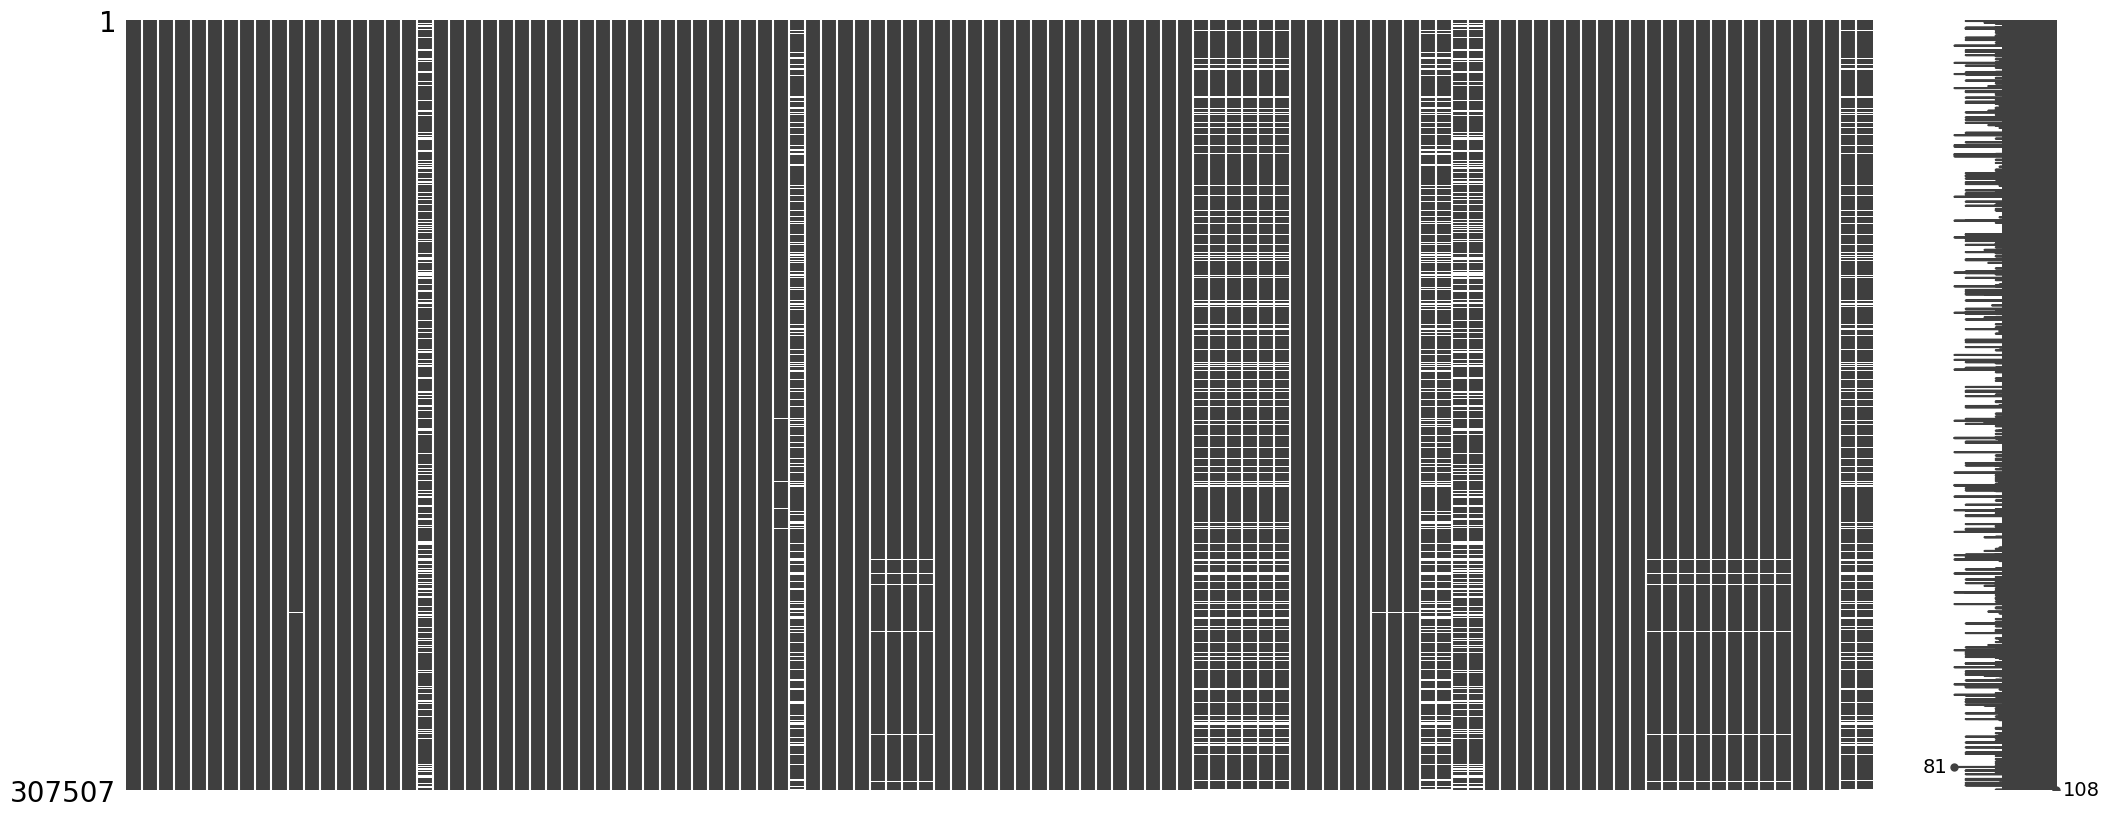

In [82]:
msno.matrix(application_train_light)

### une peu d'eda sur les table nouvellement crées

In [40]:
print("-"*100)
print("Merging TARGET with bureau Table")
bureau_merged = application_train.iloc[:,:2].merge(bureau_merged_aggregated, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with bureau Table
----------------------------------------------------------------------------------------------------


In [48]:
bureau_merged_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305811 entries, 100001 to 456255
Columns: 242 entries, DAYS_CREDIT_MEAN_OVERALL to WEIGHTED_STATUS_MEAN_MAXCREDIT_ACTIVE_REST
dtypes: float64(242)
memory usage: 567.0 MB


In [ ]:
supprimer_colonnes_manquantes(df, seuil)

==============================
==============================

# merge tables

In [86]:
#merging application_train and application_test with Aggregated bureau table
app_train_merged = application_train.merge(bureau_merged_aggregated, on = 'SK_ID_CURR', how = 'left')
app_test_merged = application_test.merge(bureau_merged_aggregated, on = 'SK_ID_CURR', how = 'left')
#merging with aggregated previous_applications
app_train_merged = app_train_merged.merge(previous_application_aggregated, on = 'SK_ID_CURR', how = 'left')
app_test_merged = app_test_merged.merge(previous_application_aggregated, on = 'SK_ID_CURR', how = 'left')

In [87]:
app_train_merged.shape

(307507, 642)

#### observation rapide sur le nouveau jeu de données

In [57]:
import missingno as msno 

<Axes: >

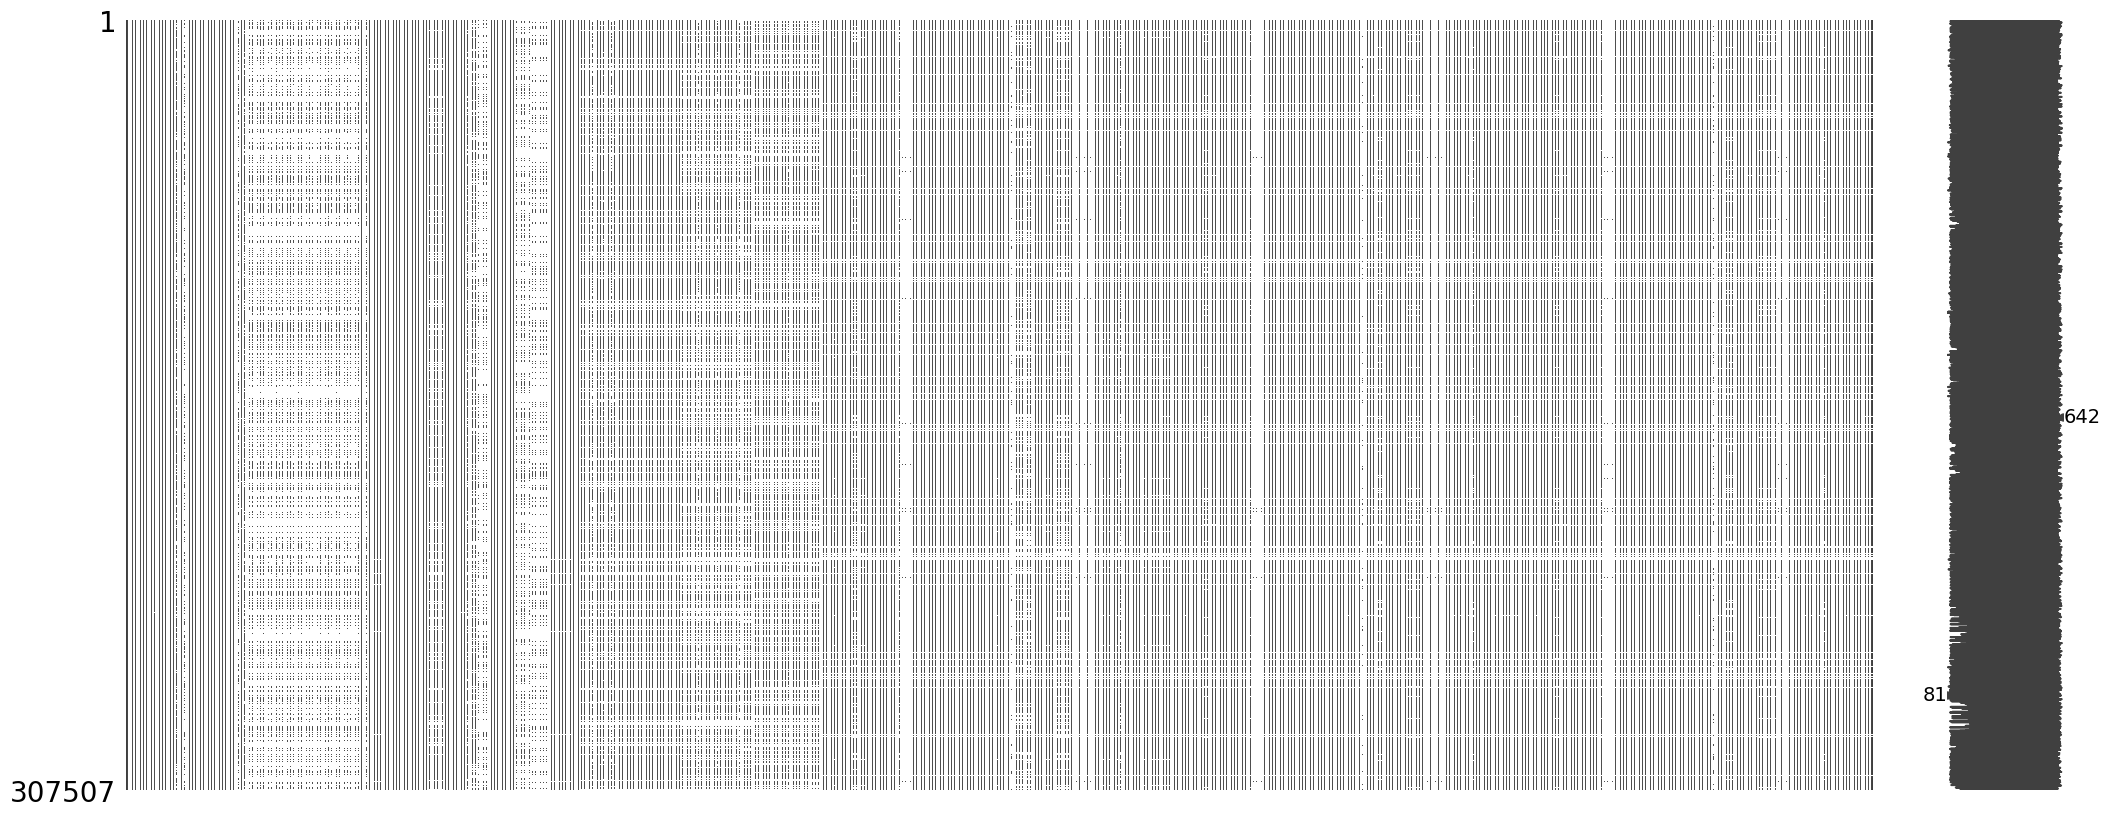

In [88]:
msno.matrix(app_train_merged)

In [89]:
app_train_merged.shape

(307507, 642)

###### suppression de colonnes avec 80% Nan value

In [93]:
app_train_merged_light = supprimer_colonnes_manquantes(app_train_merged,0.20)

<Axes: >

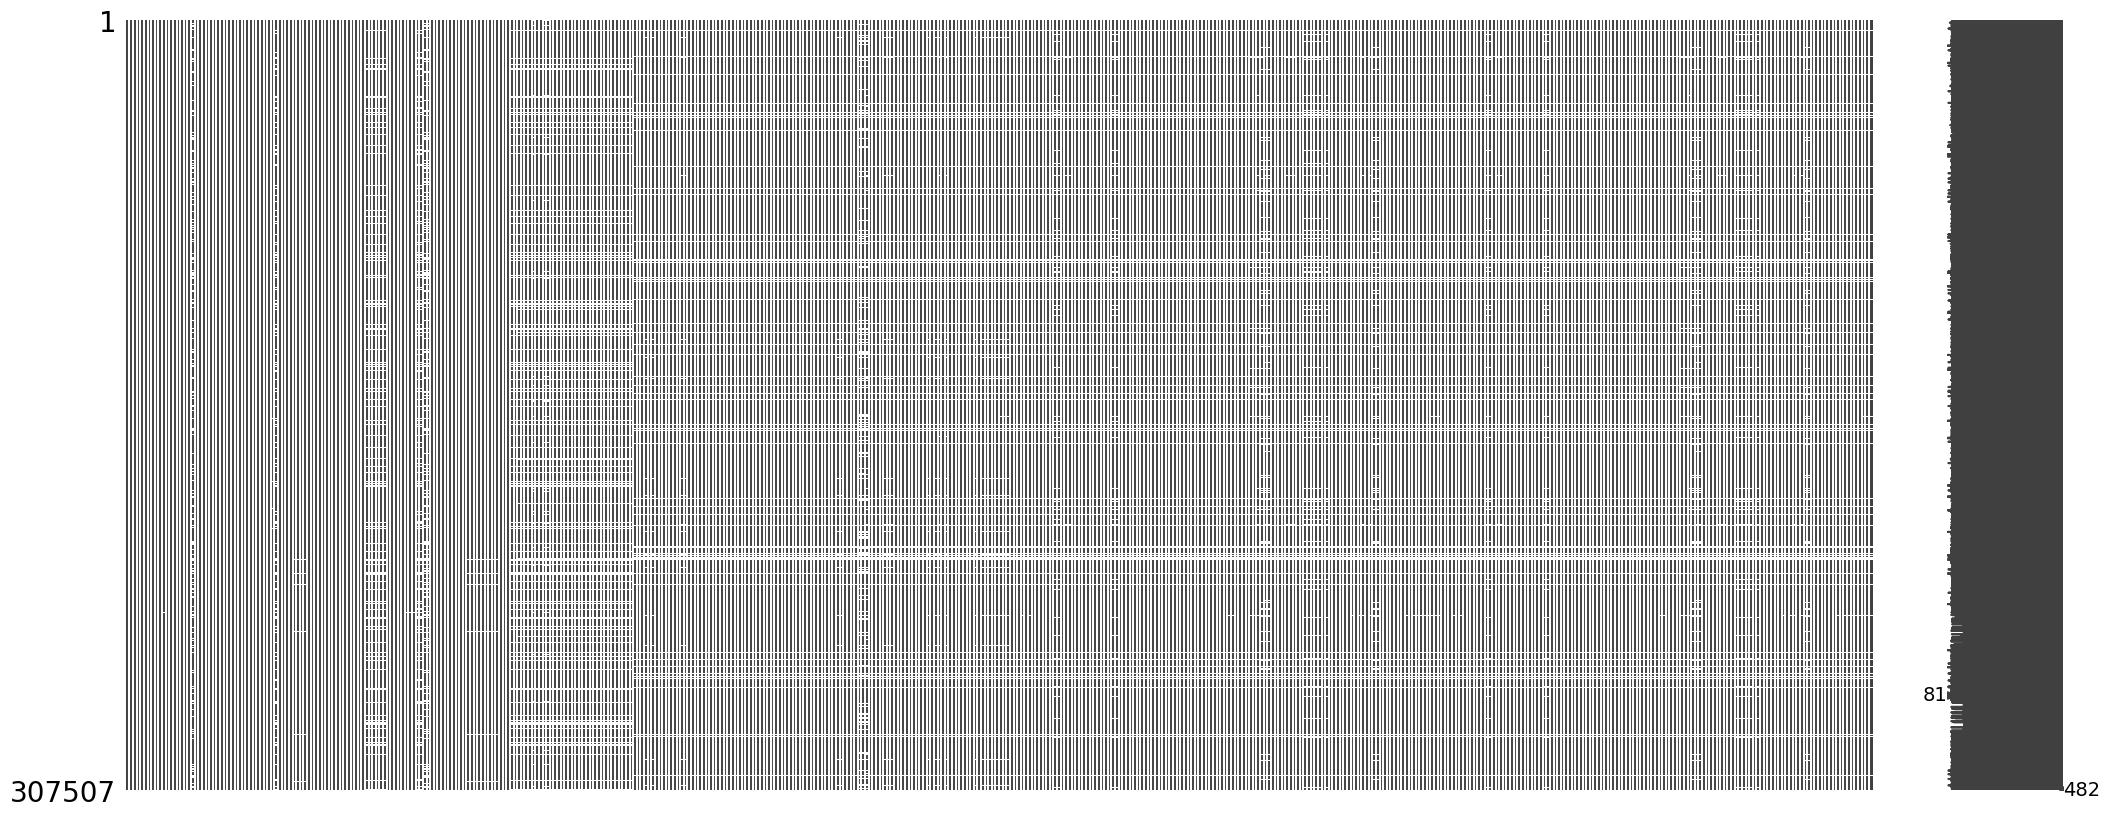

In [94]:
msno.matrix(app_train_merged_light)

In [95]:
app_train_merged_light

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_INTEREST_MEAN_ALL,AMT_INTEREST_SUM_ALL,AMT_INTEREST_MAX_ALL,AMT_INTEREST_MIN_ALL,INTEREST_SHARE_MEAN_ALL,INTEREST_SHARE_MAX_ALL,INTEREST_SHARE_MIN_ALL,INTEREST_RATE_MEAN_ALL,INTEREST_RATE_MAX_ALL,INTEREST_RATE_MIN_ALL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,42987.60000,42987.60,42987.60,42987.60,0.240080,0.240080,0.240080,0.230477,0.230477,0.230477
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,65321.55000,195964.65,144401.94,12794.22,0.146201,0.188002,0.111200,0.328564,0.381257,0.257354
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,1323.00000,1323.00,1323.00,1323.00,0.065801,0.065801,0.065801,0.315846,0.315846,0.315846
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,200877.96000,1205267.76,662797.80,-270000.00,0.246530,0.731069,-1.000000,-3.614108,0.623546,-24.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,106746.27000,640477.62,340127.28,3726.90,0.529226,1.195947,0.254988,0.598130,0.822265,0.387148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,12392.28000,12392.28,12392.28,12392.28,0.306323,0.306323,0.306323,0.816860,0.816860,0.816860
307503,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,3625.29000,3625.29,3625.29,3625.29,0.063801,0.063801,0.063801,0.218748,0.218748,0.218748
307504,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,4023.58500,8047.17,6100.29,1946.88,0.181506,0.223405,0.139606,0.718035,0.765959,0.670110
307505,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,34161.93000,68323.86,57629.70,10694.16,0.365671,0.498423,0.232919,0.563152,0.797477,0.328827


### base line model

In [96]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold 
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import KFold , cross_val_score, learning_curve, StratifiedKFold

###### fonction utiles evaluation model

##### traitement sans pipelin

In [97]:
app_train_merged_light['REGIONS_RATING_INCOME_MUL'] = app_train_merged_light['REGIONS_RATING_INCOME_MUL'].astype(int)

In [98]:
X = app_train_merged_light.drop('TARGET', axis=1)
y = app_train_merged_light['TARGET']

In [99]:
cat = X.select_dtypes(include='object')
cat.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
       'REGION_RATING_MEAN', 'REGION_RATING_MUL'],
      dtype='object')

In [100]:
cat

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,REGION_RATING_MEAN,REGION_RATING_MUL
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,2,2,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No,2.0,4
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,1,1,MONDAY,School,reg oper account,block of flats,Block,No,1.0,1
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,2,2,MONDAY,Government,XNA,XNA,XNA,XNA,2.0,4
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,2,2,WEDNESDAY,Business Entity Type 3,XNA,XNA,XNA,XNA,2.0,4
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,2,2,THURSDAY,Religion,XNA,XNA,XNA,XNA,2.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,1,1,THURSDAY,Services,reg oper account,block of flats,"Stone, brick",No,1.0,1
307503,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,XNA,2,2,MONDAY,XNA,reg oper account,block of flats,"Stone, brick",No,2.0,4
307504,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,3,3,THURSDAY,School,reg oper account,block of flats,Panel,No,3.0,9
307505,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,2,2,WEDNESDAY,Business Entity Type 1,XNA,block of flats,"Stone, brick",No,2.0,4


In [101]:
encoder=OneHotEncoder(sparse_output=False)
cat = pd.DataFrame(encoder.fit_transform(cat[['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
       'REGION_RATING_MEAN', 'REGION_RATING_MUL']]))
cat.columns = encoder.get_feature_names_out(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
        'REGION_RATING_MEAN', 'REGION_RATING_MUL'])


In [102]:
cat

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,...,REGION_RATING_MEAN_1.5,REGION_RATING_MEAN_2.0,REGION_RATING_MEAN_2.5,REGION_RATING_MEAN_3.0,REGION_RATING_MUL_1,REGION_RATING_MUL_2,REGION_RATING_MUL_3,REGION_RATING_MUL_4,REGION_RATING_MUL_6,REGION_RATING_MUL_9
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
307503,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
307504,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
307505,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [103]:
norm = X.select_dtypes(exclude = 'object')
norm

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,AMT_INTEREST_MEAN_ALL,AMT_INTEREST_SUM_ALL,AMT_INTEREST_MAX_ALL,AMT_INTEREST_MIN_ALL,INTEREST_SHARE_MEAN_ALL,INTEREST_SHARE_MAX_ALL,INTEREST_SHARE_MIN_ALL,INTEREST_RATE_MEAN_ALL,INTEREST_RATE_MAX_ALL,INTEREST_RATE_MIN_ALL
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637.0,-3648.0,...,42987.60000,42987.60,42987.60,42987.60,0.240080,0.240080,0.240080,0.230477,0.230477,0.230477
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,-1188.0,-1186.0,...,65321.55000,195964.65,144401.94,12794.22,0.146201,0.188002,0.111200,0.328564,0.381257,0.257354
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,52.180822,-225.0,-4260.0,...,1323.00000,1323.00,1323.00,1323.00,0.065801,0.065801,0.065801,0.315846,0.315846,0.315846
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,52.068493,-3039.0,-9833.0,...,200877.96000,1205267.76,662797.80,-270000.00,0.246530,0.731069,-1.000000,-3.614108,0.623546,-24.000000
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,54.608219,-3038.0,-4311.0,...,106746.27000,640477.62,340127.28,3726.90,0.529226,1.195947,0.254988,0.598130,0.822265,0.387148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,456251,0,157500.0,254700.0,27558.0,225000.0,0.032561,25.553425,-236.0,-8456.0,...,12392.28000,12392.28,12392.28,12392.28,0.306323,0.306323,0.306323,0.816860,0.816860,0.816860
307503,456252,0,72000.0,269550.0,12001.5,225000.0,0.025164,56.917808,NaN,-4388.0,...,3625.29000,3625.29,3625.29,3625.29,0.063801,0.063801,0.063801,0.218748,0.218748,0.218748
307504,456253,0,153000.0,677664.0,29979.0,585000.0,0.005002,41.002740,-7921.0,-6737.0,...,4023.58500,8047.17,6100.29,1946.88,0.181506,0.223405,0.139606,0.718035,0.765959,0.670110
307505,456254,0,171000.0,370107.0,20205.0,319500.0,0.005313,32.769863,-4786.0,-2562.0,...,34161.93000,68323.86,57629.70,10694.16,0.365671,0.498423,0.232919,0.563152,0.797477,0.328827


In [104]:
# Obtenez les noms de colonnes avant la normalisation
columns_before = norm.columns.tolist()

In [105]:
# Créez une instance de StandardScaler et ajustez-le aux données
scaler = StandardScaler()
norm_scaled = scaler.fit_transform(norm)

In [106]:
# Reconstruisez un DataFrame pandas avec les données normalisées
norm_scaled_df = pd.DataFrame(norm_scaled, columns=columns_before)

In [107]:
norm_scaled_df

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,AMT_INTEREST_MEAN_ALL,AMT_INTEREST_SUM_ALL,AMT_INTEREST_MAX_ALL,AMT_INTEREST_MIN_ALL,INTEREST_SHARE_MEAN_ALL,INTEREST_SHARE_MAX_ALL,INTEREST_SHARE_MIN_ALL,INTEREST_RATE_MEAN_ALL,INTEREST_RATE_MAX_ALL,INTEREST_RATE_MIN_ALL
0,-1.733433,-0.577534,0.142129,-0.478099,-0.166152,-0.507239,-0.149444,-1.506889,0.747177,0.379840,...,-0.167288,-0.335386,-0.536890,0.571164,0.207232,-0.626888,0.784622,0.513059,-0.097109,0.696362
1,-1.733423,-0.577534,0.426790,1.725436,0.592657,1.599967,-1.252739,0.166814,0.511538,1.078701,...,-0.012758,-0.165808,-0.239830,0.413481,-0.141895,-0.771612,0.559185,0.536760,-0.024769,0.698703
2,-1.733414,-0.577534,-0.427192,-1.152889,-1.404649,-1.091897,-0.783441,0.689503,0.923372,0.206119,...,-0.455567,-0.381572,-0.658933,0.353573,-0.440890,-1.111209,0.479774,0.533687,-0.056151,0.703799
3,-1.733394,-0.577534,-0.142532,-0.711433,0.177858,-0.653403,-0.928980,0.680108,-0.280054,-1.375827,...,0.925163,0.953026,1.278644,-1.063395,0.231218,0.737567,-1.384515,-0.415911,0.091474,-1.414560
4,-1.733384,-0.577534,-0.199464,-0.213740,-0.361753,-0.068745,0.563577,0.892529,-0.279627,0.191642,...,0.273862,0.326944,0.333485,0.366127,1.282527,2.029462,0.810697,0.601895,0.186814,0.710011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,1.732362,-0.577534,-0.047645,-0.855492,0.031002,-0.848290,0.845402,-1.537595,0.918668,-0.984953,...,-0.378978,-0.369302,-0.626509,0.411382,0.453578,-0.442801,0.900492,0.654747,0.184221,0.747447
307503,1.732372,-0.577534,-0.408215,-0.818597,-1.042321,-0.848290,0.310600,1.085701,NaN,0.169785,...,-0.439637,-0.379020,-0.652189,0.365597,-0.448327,-1.116767,0.476276,0.510225,-0.102736,0.695340
307504,1.732382,-0.577534,-0.066622,0.195371,0.198039,0.126141,-1.147109,-0.245425,-2.367875,-0.497000,...,-0.436881,-0.374118,-0.644940,0.356831,-0.010601,-0.673229,0.608873,0.630868,0.159800,0.734662
307505,1.732392,-0.577534,0.009288,-0.568761,-0.476319,-0.592502,-1.124624,-0.934017,-1.027171,0.688111,...,-0.228353,-0.307300,-0.494001,0.402513,0.674287,0.091045,0.772096,0.593443,0.174921,0.704930


In [108]:
# Maintenant, fusionnez vos données encodées et normalisées
X_processed = pd.concat([cat, norm_scaled_df], axis=1)

In [109]:
def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values
    
    Inputs:
        df_nan: 
            DataFrame of NaN percentages
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels

    '''
    
    #checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")
        
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")



In [110]:
def nan_df_create(data):
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

Number of columns having NaN values: 416 columns


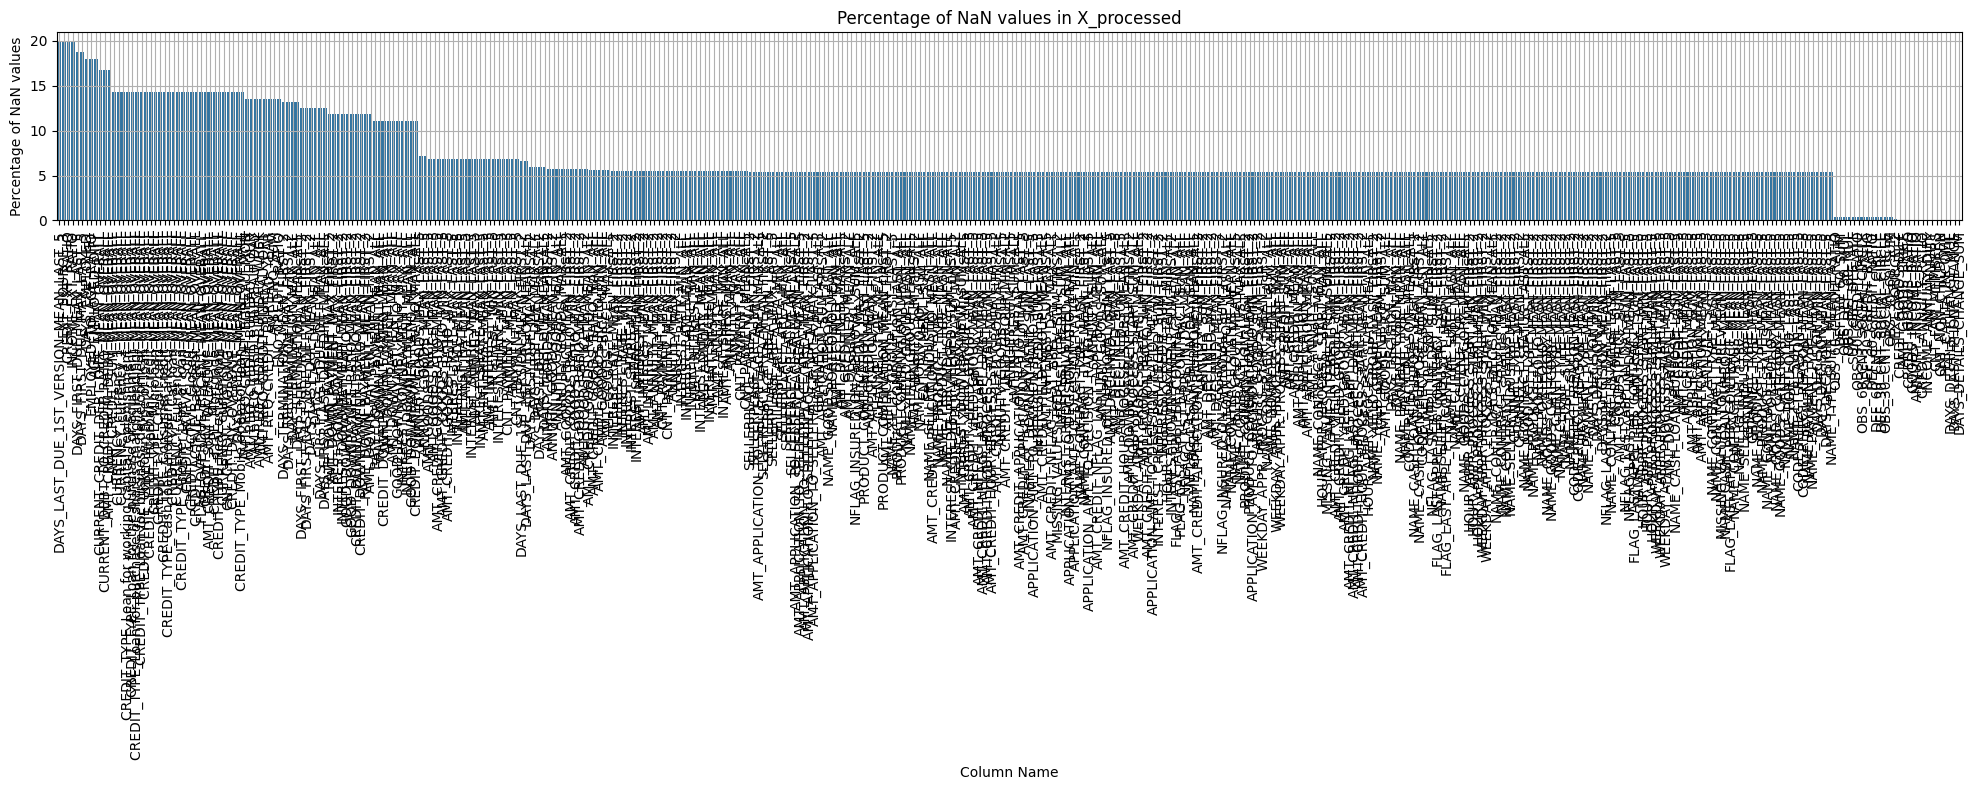

In [111]:
plot_nan_percent(nan_df_create(X_processed), 'X_processed', grid = True)

Gros probleme de memoire, je me retrouve avec un jeu de donnée trop voluimineux je ne peusx plus rien faire, 
l'idée est de revenir avant la grande jointure
faire mes reduction de dimentions sur les 3 table indemendamment les une des autre, puis ensuite merge des tables plus legères

In [115]:
A = supprimer_colonnes_manquantes(X_processed, 0.1)

Number of columns having NaN values: 337 columns


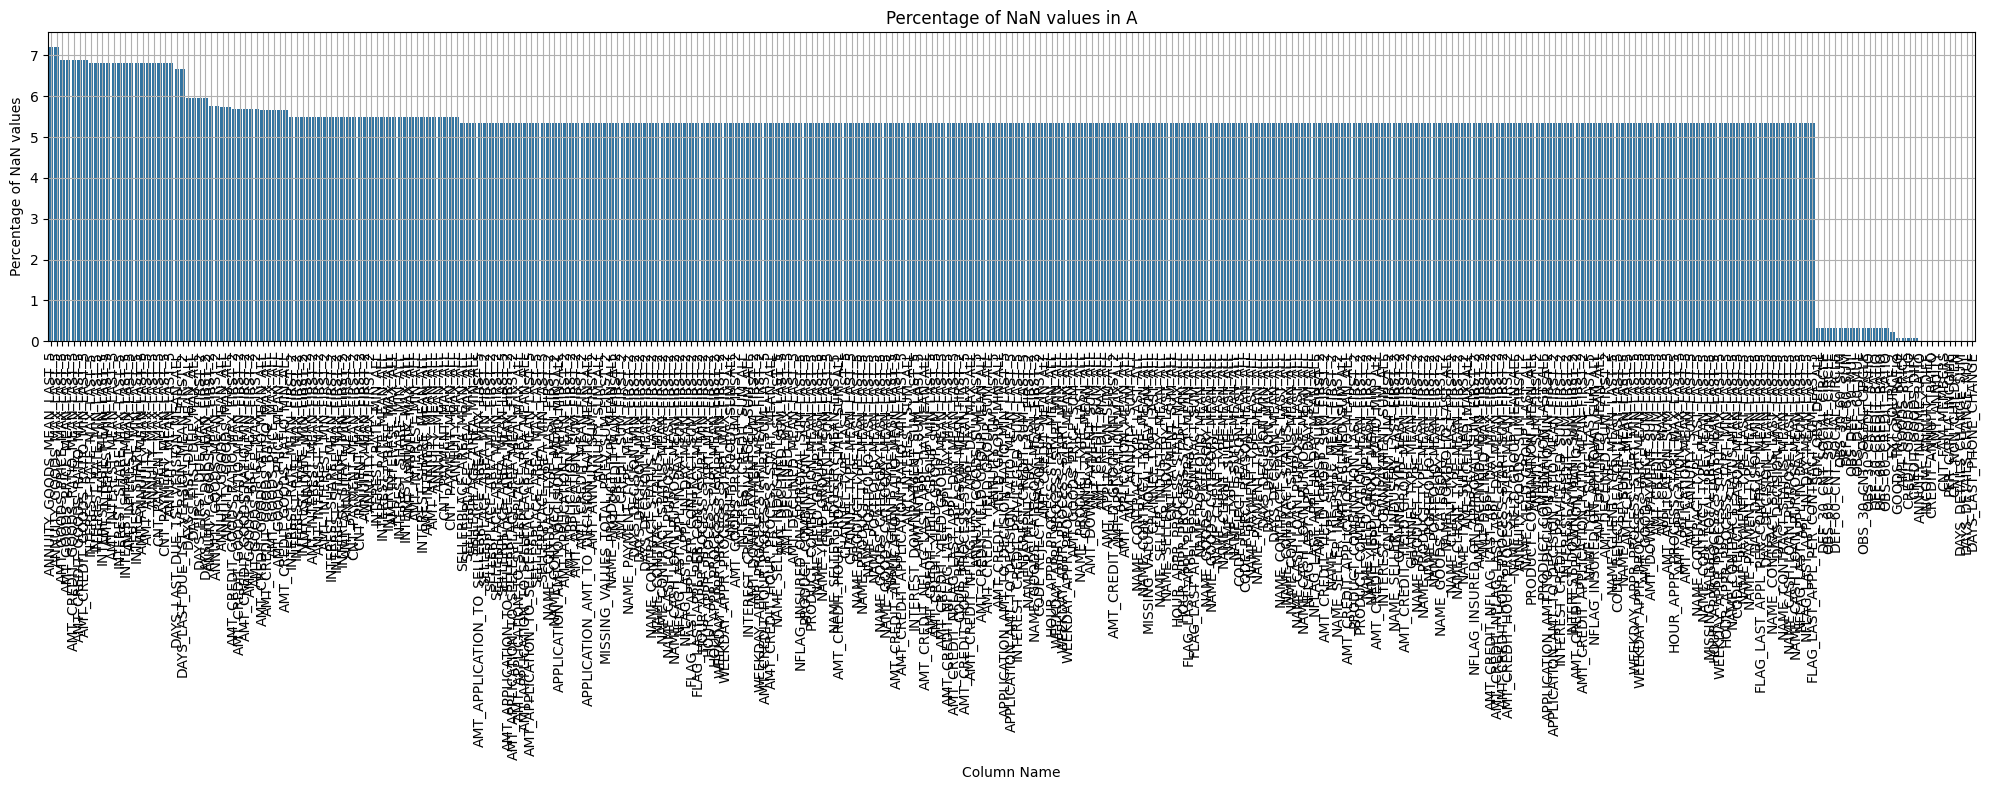

In [116]:
plot_nan_percent(nan_df_create(A), 'A', grid = True)

###### preparation pipeline

In [158]:

numeric_features = app_train_merged_light.select_dtypes(exclude='object')
categorical_features = app_train_merged_light.select_dtypes(include='object')

In [159]:
# Création de la pipeline pour le prétraitement des données
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [160]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [175]:
preprocessor.fit_transform(app_train_merged_light)

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

###### definition x et y

In [162]:
X = app_train_merged_light.drop('TARGET', axis=1)
y = app_train_merged_light['TARGET']

###### cross validation

In [163]:
# Définition de la stratégie de validation croisée stratifiée
ckf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

###### split données entrainement et test

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

###### reequilibrage undersampling

In [165]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

In [166]:
model = LogisticRegression()

In [167]:
# Création de la pipeline complète avec ImbPipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', rus),
    ('classifier', model)
])

In [168]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                          SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0           100002       1             0          202500.0    406597.5   
1           100003       0             0          270000.0   1293502.5   
2           100004       0             0           67500.0    135000.0   
3           100006       0             0          135000.0    312682.5   
4           100007       0             0          121500.0    513000.0   
...            ...     ...           ...               ...         ...   
307502      456251       0             0          1575...
307502       Stone, brick                  No                  157500.0   
307503       Stone, brick                  No                  144000.0   
307504              Panel                  No                  459000.0   
307505       Stone, brick                  No                  342000.0   
307506              Panel                  No                  157500.0   

       REGION_RATING_MEAN REGION_RATING_MUL  
0                     2.0                 4  
1                     1.0                 1  
2                     2.0                 4  
3                     2.0                 4  
4                     2.0                 4  
...                   ...               ...  
307502                1.0                 1  
307503                2.0                 4  
307504                3.0                 9  
307505                2.0                 4  
307506                1.0                 1  

[307507 rows x 21 columns])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classifier', LogisticRegression())])

In [120]:
# scoring
#scores = cross_val_score(model,X_res,y_res,scoring='accuracy',cv=ckf, n_jobs=-1)

In [169]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape, X_res.shape, y_res.shape)

(246005, 660) (246005,) (61502, 660) (61502,) (39720, 660) (39720,)


###### observation données ressamplées

<Axes: >

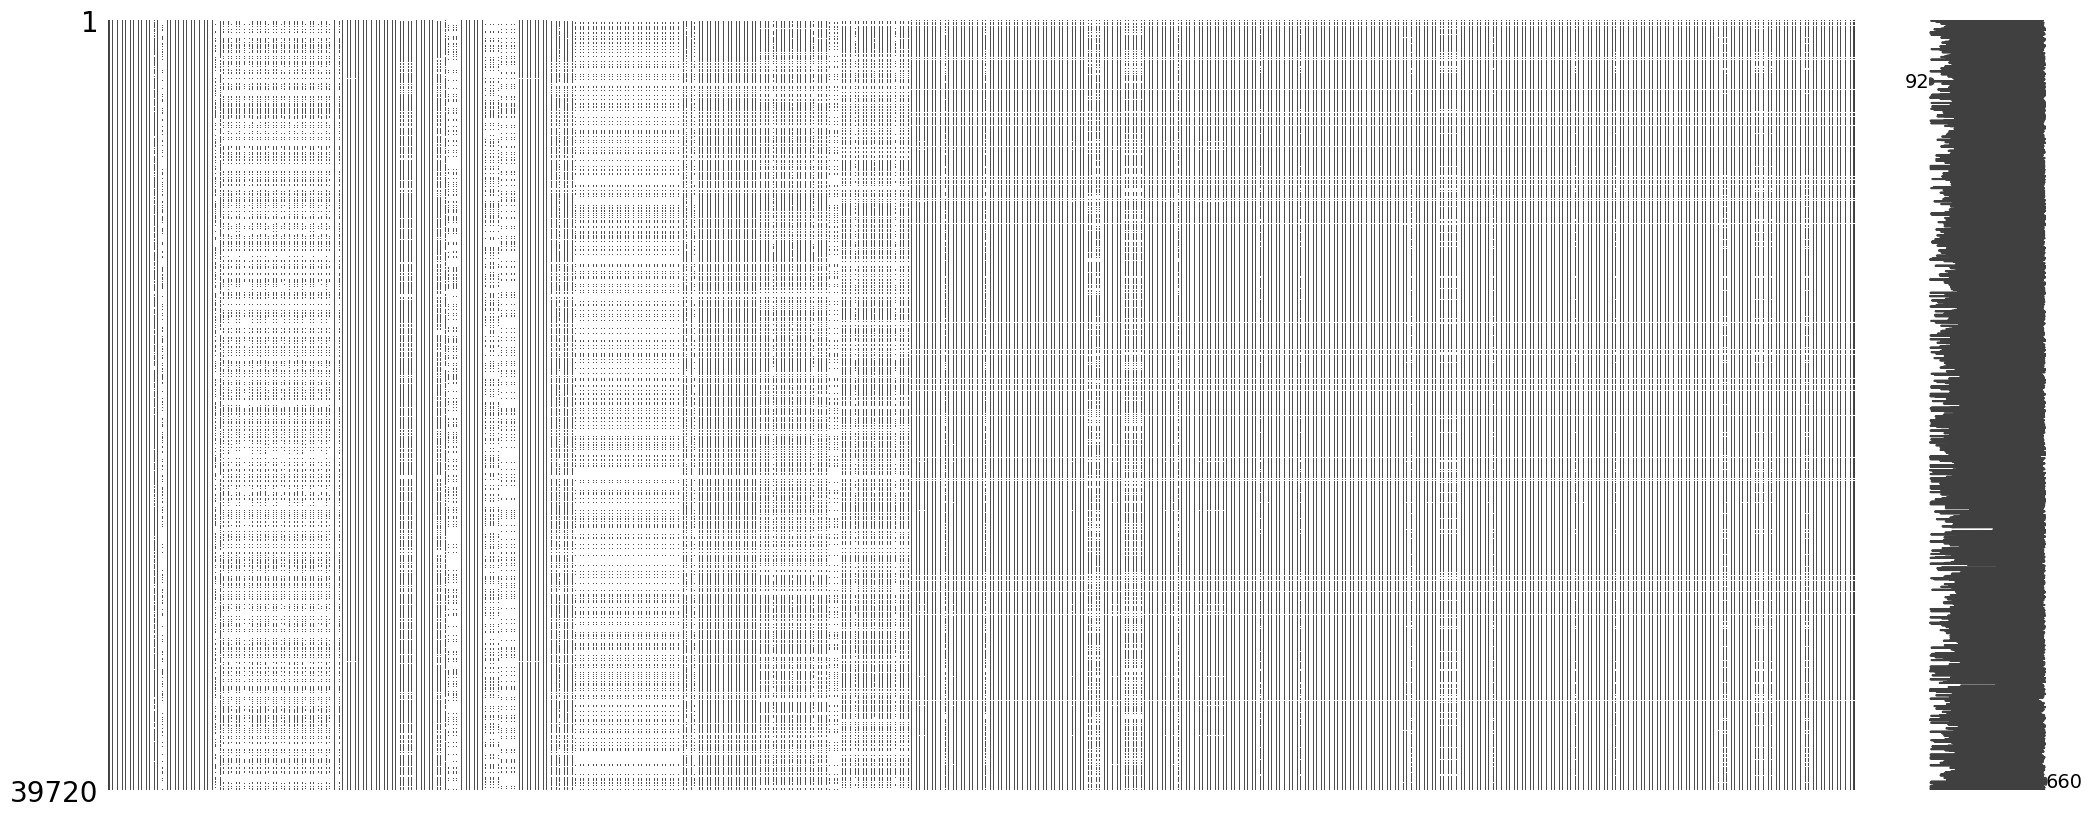

In [170]:
msno.matrix(X_res)

In [128]:
X_res

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AMT_INTEREST_MEAN_ALL,AMT_INTEREST_SUM_ALL,AMT_INTEREST_MAX_ALL,AMT_INTEREST_MIN_ALL,INTEREST_SHARE_MEAN_ALL,INTEREST_SHARE_MAX_ALL,INTEREST_SHARE_MIN_ALL,INTEREST_RATE_MEAN_ALL,INTEREST_RATE_MAX_ALL,INTEREST_RATE_MIN_ALL
155384,280127,Cash loans,F,N,N,1,180000.0,450000.0,20979.0,450000.0,...,30997.620000,30997.62,30997.62,30997.62,0.438442,0.438442,0.438442,0.809431,0.809431,0.809431
2971,103468,Cash loans,F,N,N,0,130500.0,503266.5,24210.0,503266.5,...,238912.765714,1672389.36,688863.60,0.00,0.435349,0.724159,0.000000,0.426433,0.972469,0.220800
91423,206172,Cash loans,F,N,Y,0,171000.0,450000.0,29430.0,450000.0,...,42560.460000,42560.46,42560.46,42560.46,0.217358,0.217358,0.217358,0.401276,0.401276,0.401276
66812,177476,Cash loans,M,Y,Y,0,315000.0,1006920.0,39933.0,900000.0,...,235645.860000,1413875.16,1467081.90,-180000.00,0.135513,0.582800,-1.000000,-3.450036,0.809431,-24.000000
254633,394658,Revolving loans,M,Y,Y,1,126000.0,180000.0,9000.0,180000.0,...,63119.520000,126239.04,103271.94,22967.10,0.338827,0.430569,0.247086,0.625527,0.794896,0.456158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38044,144059,Cash loans,F,N,Y,0,193500.0,408330.0,22279.5,292500.0,...,256682.610000,2310143.49,427482.18,98928.81,0.569244,0.840680,0.371241,0.350109,0.842265,0.240805
217851,352408,Cash loans,F,N,Y,1,67500.0,604152.0,25726.5,540000.0,...,185888.100000,557664.30,410061.60,9200.70,0.575152,0.740443,0.472412,0.583095,0.872146,0.396852
2747,103205,Cash loans,F,N,Y,0,90000.0,495216.0,20169.0,427500.0,...,123824.160000,123824.16,123824.16,123824.16,0.745098,0.745098,0.745098,0.415869,0.415869,0.415869
87498,201563,Cash loans,M,Y,Y,0,292500.0,1215000.0,43177.5,1215000.0,...,73552.803750,588422.43,409013.10,-270000.00,0.225555,1.068558,-1.000000,-5.642934,0.693118,-24.000000


=============== Lancement baselibne ==============

In [124]:
model.fit(X_res,y_res)

ValueError: could not convert string to float: 'Cash loans'

In [ ]:
y_pred = model.predict(X_test)

In [97]:
# # Exemple d'utilisation de la pipeline avec la validation croisée
# for train_index, test_index in skf.split(X, y): # Remplacer X et y par vos données
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     print("Distribution des classes avant sous-échantillonnage:")
#     print_class_distribution(y_train)

#     # Entraînement du modèle
#     pipeline.fit(X_train, y_train)

#     # Évaluation du modèle
#     print("Score sur le jeu de test:", pipeline.score(X_test, y_test))

#     print("Distribution des classes après sous-échantillonnage:")
#     print_class_distribution(y_train)



Distribution des classes avant sous-échantillonnage:
Distribution des classes après sous-échantillonnage: Counter({0: 254414, 1: 22342})


ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed